# TRABAJO 1: ENSEMBLE LEARNING | MACHINE LEARNING II
## Feb 2023
--- 

### GRUPO: G9
- Carlota Monedero Herranz
- José Manuel Vega Gradit
- Jorge Ayuso Martínez
- Javier Gisbert Gil
- Diego Sanz-Gadea Sánchez

--- 

**IMPORTANTE:**
- Asegúrate, fijando la semilla de los nº aleatorios según proceda, que si se vuelve a ejecutar el cuaderno los resultados son idénticos
- Responde a las preguntas planteadas utilizando instrucciones "print" que permitan leer cómodamente como resultado de la ejecución de la celda el texto explicativo junto a las figuras o tablas a las que haga referencia (mira el ejemplo en la primera gráfica que se representa). También puedes usar markdown para responder.
- No escribas líneas de código muy largas, tienes una regla para ayudarte a no hacerlo
- No cambies la estructura del documento, respeta las secciones que ya existen


In [1]:
# !pip install plotly
# !pip install imbalanced-learn
# !pip install threadpoolctl==3.1.0
# !pip install patsy
# !pip install nbformat
# !pip install lightgbm
# !pip install bayesian-optimization

---
Importamos todos los paquetes aquí por comodidad

In [52]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

# Libreríasc clásicas de Data Science
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px

# Scikit-Learns modules
# Preprocessing
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, accuracy_score

# Modelling
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

# Metrics
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.calibration import CalibratedClassifierCV
import lightgbm as lgb
from bayes_opt import BayesianOptimization, UtilityFunction

# mltools
# from mltools import classification_tools as CT
from mltools import model_tools as MT

Para mejorar la estética de las gráficas, hacemos uso de `seaborn`:

In [3]:
sns.set()

Con el siguiente comando podemos calibrar el número de columnas del DataFrame que se muestran:

In [4]:
pd.set_option('display.max_columns', None)

## 1. AJUSTE DE LOS MODELOS CON EL DATASET `AJU_DATOS_DEM_C3.csv`

Se trata de estimar la variable FESTIVO (1: el día es festivo) a partir de las variables disponibles en el dataset que se consideren oportunas. NO se pueden utilizar como variables de entrada: FECHA, DIA ni AÑO. La FECHA es interesante manejarla simplemente como ayuda para entender lo que esté pasando.

Se deben ajustar diferentes modelos, buscando un buen compromiso entre la complejidad y el error en cada uno de ellos. El objetivo es conseguir un buen modelo con una gran capacidad de acierto en el futuro. Modelos que deben crearse, analizando los resultados de cada uno de ellos (errores e importancias de las variables):
- Simple tree
- Bagged  tree
- Random Forest
- Gradient boosting
- Stacking

#### Carga de datos:

In [5]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

df_aju = pd.read_csv('data/input/AJU_DATOS_DEM_C3.csv')

# Parseamos la fecha (cadena) para que sea un datetime con formato dd/mm/yyyy 
# Nota: esta variable NO se puede utilizar como entrada en los modelos
df_aju.FECHA = pd.to_datetime(df_aju.FECHA, format="%d/%m/%Y") 
s = df_aju.loc[:, 'FECHA']
df_aju['FECHA'] =  s.dt.date

# Eliminamos las variables que no se pueden usar como entradas en los modelos
del df_aju['ANNO']
del df_aju['DIA']

print('Tamaño de df_orig con los datos cargados:', df_aju.shape)
print('Dataframe con todos los datos leidos (filas: días, columnas: variables):')
df_aju.head()

Tamaño de df_orig con los datos cargados: (2879, 30)
Dataframe con todos los datos leidos (filas: días, columnas: variables):


FECHA      CR00      CR01      CR02      CR03      CR04      CR05  \
0  2014-01-01  0.040942  0.038985  0.036382  0.034416  0.033409  0.033420   
1  2014-01-02  0.033950  0.030996  0.029517  0.028966  0.029165  0.030150   
2  2014-01-03  0.035463  0.032112  0.030292  0.029521  0.029450  0.030515   
3  2014-01-04  0.035959  0.032772  0.031034  0.030178  0.030135  0.030782   
4  2014-01-05  0.037506  0.034148  0.031878  0.031126  0.030930  0.031604   

       CR06      CR07      CR08      CR09      CR10      CR11      CR12  \
0  0.034054  0.034229  0.035889  0.039427  0.041801  0.042122  0.042366   
1  0.032944  0.036510  0.041196  0.045132  0.046170  0.045324  0.044659   
2  0.033188  0.036656  0.041052  0.046046  0.047047  0.044796  0.044318   
3  0.032598  0.034982  0.039299  0.044597  0.046754  0.046050  0.044611   
4  0.033066  0.034803  0.038758  0.043760  0.045930  0.045478  0.044804   

       CR13      CR14      CR15      CR16      CR17      CR18      CR19  \
0  0.043396  0.042980  0.040835  0.041026  0.044652  0.051983  0.055197   
1  0.045434  0.045281  0.043589  0.043362  0.045939  0.052936  0.055820   
2  0.044846  0.044694  0.043458  0.043363  0.045908  0.052802  0.055230   
3  0.045670  0.045926  0.044732  0.044316  0.046249  0.051650  0.053757   
4  0.045645  0.045275  0.043290  0.043349  0.046256  0.051721  0.052902   

       CR20      CR21      CR22      CR23  MES  DIASEM  FESTIVO  TMIN  TMAX  
0  0.054185  0.051063  0.046240  0.041000    1       3        1  12.3  20.2  
1  0.054451  0.051482  0.046145  0.040880    1       4        0  12.0  20.1  
2  0.053520  0.050286  0.045412  0.040025    1       5        0  13.2  21.0  
3  0.052620  0.049973  0.044970  0.040386    1       6        0  14.4  23.4  
4  0.051481  0.049655  0.045730  0.040905    1       7        0  12.8  23.1

#### Visión general de las series:

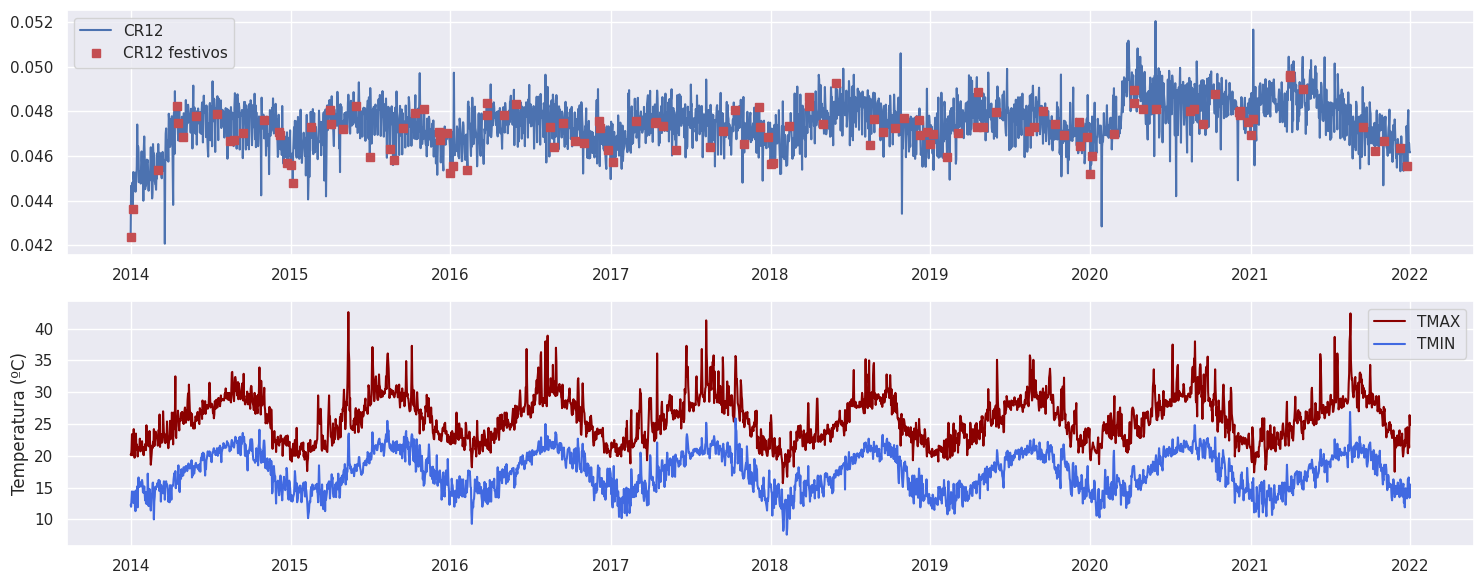

Se observa que el nº de festivos (115) es claramente inferior al nº de laborables (2764)
En concreto, el porcentaje de festivos en el conjunto de ajuste es 3.99444251476207 %


In [6]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
fig = plt.figure(1, figsize=(15,6))

ax1 = plt.subplot(2, 1, 1)
ind_festivo = df_aju.FESTIVO == 1
plt.plot(df_aju.FECHA, df_aju.CR12, label='CR12')
plt.plot(df_aju.FECHA[ind_festivo], df_aju.CR12[ind_festivo], 'sr', label='CR12 festivos')
plt.legend()

plt.subplot(2, 1, 2,sharex = ax1)
plt.plot(df_aju.FECHA, df_aju.TMAX, label='TMAX', color="darkred")
plt.plot(df_aju.FECHA, df_aju.TMIN, label='TMIN', color="royalblue")
plt.ylabel("Temperatura (ºC)")
plt.tight_layout()
plt.legend()

plt.show()

num_festivos = np.count_nonzero(df_aju.FESTIVO)
num_laborables = df_aju.shape[0] - num_festivos
print(f'Se observa que el nº de festivos ({num_festivos}) es claramente inferior al nº de laborables ({num_laborables})')
print(f'En concreto, el porcentaje de festivos en el conjunto de ajuste es {100*num_festivos /  df_aju.shape[0]} %')
# fig.savefig('figura1.pdf')

---
### 1.1 Análisis exploratorio básico del problema

- Incluye un análisis que te permita comprender la naturaleza del problema, cómo son las variables de entrada, su interrelación, así como su relación con la variable de salida
- Comenta todo lo que parezca relevante para el tema tratado, incluyendo todas las gráficas que consideres oportunas
- Estudia cómo se reparten los festivos según el día de la semana y los meses

Vemos en primer lugar los tipos de datos de cada variable, así como la posible existencia de valores nulos:

In [7]:
# Ver datatypes
df_aju.dtypes

FECHA       object
CR00       float64
CR01       float64
CR02       float64
CR03       float64
CR04       float64
CR05       float64
CR06       float64
CR07       float64
CR08       float64
CR09       float64
CR10       float64
CR11       float64
CR12       float64
CR13       float64
CR14       float64
CR15       float64
CR16       float64
CR17       float64
CR18       float64
CR19       float64
CR20       float64
CR21       float64
CR22       float64
CR23       float64
MES          int64
DIASEM       int64
FESTIVO      int64
TMIN       float64
TMAX       float64
dtype: object

In [8]:
# Revisamos que columnas tienen valores nulos
null_values = df_aju.isnull().sum()
null_values[null_values>0].index.tolist()

[]

In [9]:
#Añadimos la fecha como datetime
df_aju['FECHA'] = pd.to_datetime(df_aju['FECHA'], format='%Y-%m-%d')
df_aju.set_index('FECHA', inplace=True)

Podemos observar que ninguna columna tiene valores nulos. Adicionalmente, los tipos de datos son los correctos, de forma que no es necesario realizar ningún cambio al respecto.

A continuación vamos a analizar los datos que tenemos desde un punto de vista estadístico:

In [10]:
df_aju.describe()

CR00         CR01         CR02         CR03         CR04  \
count  2879.000000  2879.000000  2879.000000  2879.000000  2879.000000   
mean      0.034957     0.032494     0.030964     0.030305     0.030266   
std       0.001606     0.002285     0.001341     0.001227     0.001107   
min       0.030414     0.027836     0.026304     0.026362     0.027067   
25%       0.033770     0.031340     0.029996     0.029424     0.029463   
50%       0.034726     0.032124     0.030687     0.030060     0.030074   
75%       0.035922     0.033320     0.031802     0.031081     0.030968   
max       0.040942     0.067164     0.036382     0.035336     0.034789   

              CR05         CR06         CR07         CR08         CR09  \
count  2879.000000  2879.000000  2879.000000  2879.000000  2879.000000   
mean      0.031063     0.033603     0.037270     0.041366     0.045223   
std       0.000955     0.000871     0.002104     0.002057     0.001498   
min       0.027963     0.028263     0.030260     0.017153     0.028013   
25%       0.030361     0.033031     0.035427     0.039913     0.044453   
50%       0.030938     0.033557     0.037093     0.041499     0.045344   
75%       0.031709     0.034129     0.039217     0.043018     0.046244   
max       0.034929     0.037046     0.041914     0.045876     0.048957   

              CR10         CR11         CR12         CR13         CR14  \
count  2879.000000  2879.000000  2879.000000  2879.000000  2879.000000   
mean      0.047050     0.046984     0.047507     0.048261     0.047648   
std       0.000995     0.000910     0.001037     0.001222     0.001100   
min       0.041063     0.041689     0.042062     0.043123     0.042364   
25%       0.046573     0.046431     0.046872     0.047506     0.046980   
50%       0.047134     0.047041     0.047549     0.048249     0.047667   
75%       0.047669     0.047585     0.048188     0.049009     0.048352   
max       0.050939     0.049904     0.052055     0.054524     0.053118   

              CR15         CR16         CR17         CR18         CR19  \
count  2879.000000  2879.000000  2879.000000  2879.000000  2879.000000   
mean      0.045344     0.044218     0.045380     0.047876     0.049790   
std       0.001059     0.001060     0.001242     0.002294     0.002797   
min       0.040525     0.038784     0.039004     0.040209     0.041802   
25%       0.044656     0.043499     0.044684     0.046561     0.047863   
50%       0.045364     0.044224     0.045475     0.047744     0.049314   
75%       0.046078     0.044959     0.046270     0.049166     0.052280   
max       0.048681     0.047659     0.048516     0.054592     0.057206   

              CR20         CR21         CR22         CR23          MES  \
count  2879.000000  2879.000000  2879.000000  2879.000000  2879.000000   
mean      0.050401     0.049120     0.043973     0.038937     6.526224   
std       0.002089     0.001359     0.001388     0.001344     3.444273   
min       0.043542     0.043666     0.038585     0.033029     1.000000   
25%       0.048883     0.048259     0.043005     0.037990     4.000000   
50%       0.050434     0.049143     0.043962     0.038882     7.000000   
75%       0.051931     0.050033     0.044932     0.039817    10.000000   
max       0.056826     0.053625     0.049216     0.043856    12.000000   

            DIASEM      FESTIVO         TMIN         TMAX  
count  2879.000000  2879.000000  2879.000000  2879.000000  
mean      4.006600     0.039944    17.460056    25.821639  
std       1.994683     0.195863     3.081945     3.677193  
min       1.000000     0.000000     7.600000    15.700000  
25%       2.000000     0.000000    15.000000    22.900000  
50%       4.000000     0.000000    17.500000    25.600000  
75%       6.000000     0.000000    20.200000    28.500000  
max       7.000000     1.000000    26.900000    42.600000

### Visualización

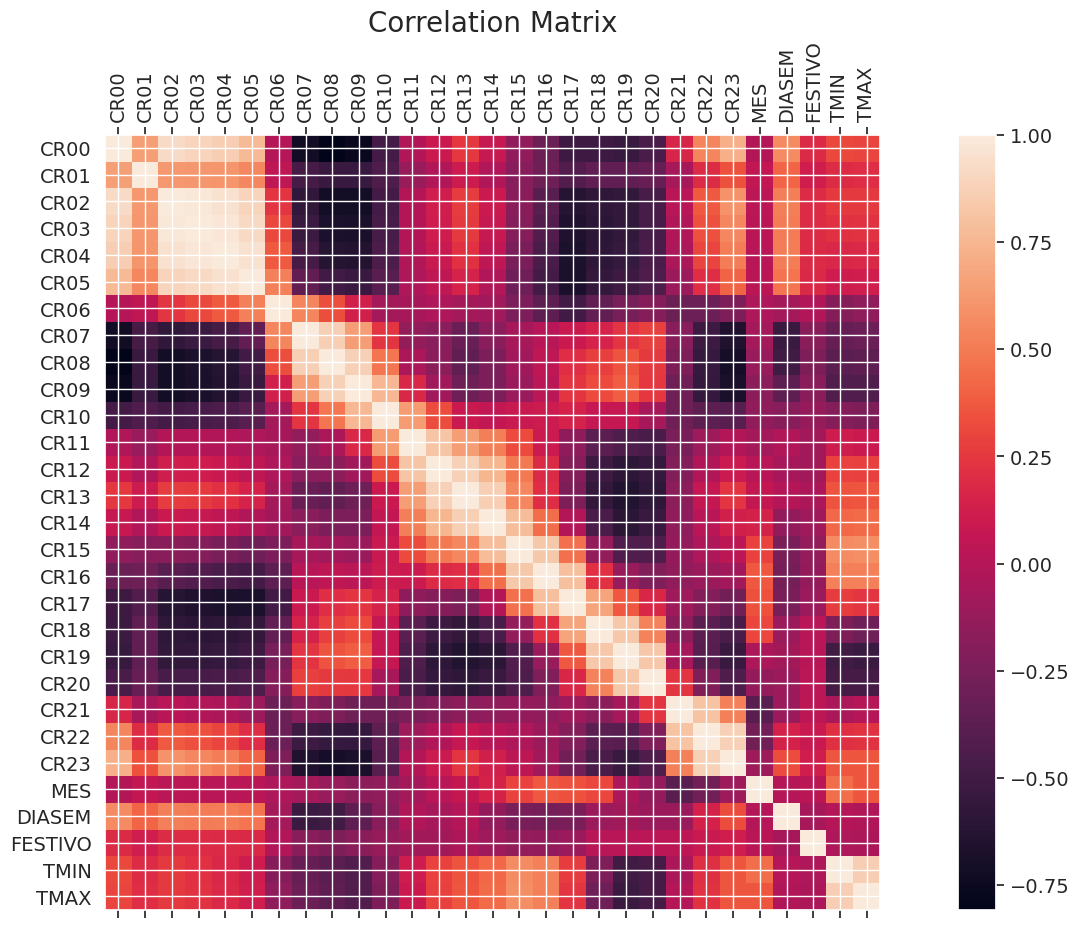

In [11]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
# Correlation plot of numeric variables
f = plt.figure(figsize=(20,10))
plt.matshow(df_aju.select_dtypes(include=['int64','float64']).corr(), fignum=f.number)

plt.xticks(range(df_aju.select_dtypes(include=['int64','float64']).shape[1]), 
           df_aju.select_dtypes(include=['int64','float64']).columns, fontsize=14, rotation=90)

plt.yticks(range(df_aju.select_dtypes(include=['int64','float64']).shape[1]), 
           df_aju.select_dtypes(include=['int64','float64']).columns, fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=20)
plt.show()

Se pueden apreciar correlaciones muy importantes entre algunos pares de variables. Sin especificar en detalle todas estas correlaciones debido a la existencia de un gran número de ellas, concuerdan con el perfil de demanda dado por lor periodos horarios de $Valle$, $Llano$ y $Punta$. Podemos apreciar que algunas de las más relevantes son:

- Correlación muy positiva entre los coeficientes de reparto del $CR00$ al $CR05$. Correspondientes a las horas $Valle$.
- Correlación muy negativa entre los coeficientes de reparto $CR00...CR05$ y los coeficientes de reparto $CR07...CR10$. Entre el $Valle$ y la $Primera Punta$.
- Correlación muy negativa entre los coeficientes de reparto $CR00...CR05$ y los coeficientes de reparto $CR16...CR20$. Entre el $Valle$ y la $Segunda Punta$.
- Correlación muy negativa entre los coeficientes de reparto $CR12...CR15$ y los coeficientes de reparto $CR18...CR20$. Entre el $Llano$ y la $Segunda Punta$.
- En general parece haber una correlación positiva entre coeficientes de reparto consecutivos, como $CR21$ y $CR22$, lo cual tiene cierto sentido desde un punto de vista lógico. Obviamente esta correlación es más clara en algunos casos que en otros.
- Correlación bastante positiva entre $T_{min}$ y $T_{max}$. También se observa que las temperaturas están correlacionadas con las horas de más y menos sol.

Hay que tener en cuenta que con este gráfico solamente somos capaces de detectar correlaciones lineales entre los datos, de forma que pueden existir otras correlaciones existentes que no sigan una relación estrictamente lineal, y que habrá que estudiar, si existen, más en detalle en siguientes puntos.

In [12]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
df = pd.melt(df_aju.reset_index(), id_vars=["FECHA",'MES', 'DIASEM','FESTIVO', 'TMIN', 'TMAX'], value_vars=['CR00', 'CR01',
    'CR02', 'CR03', 'CR04', 'CR05', 'CR06', 'CR07', 'CR08', 'CR09', 'CR10', 'CR11', 'CR12', 'CR13', 'CR14', 'CR15', 'CR16', 
    'CR17', 'CR18', 'CR19', 'CR20', 'CR21', 'CR22', 'CR23'], var_name='HORA', value_name='DEMANDA')
df['FECHA'] = df['FECHA'].astype(str) + ' ' + df['HORA'].astype(str).str[2:]
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%Y-%m-%d %H')
df = df.set_index('FECHA')
df.drop(columns=['HORA'],inplace=True)
df = df.sort_index()
festivo_mask=df.FESTIVO==1
fig = px.line(df, x=df.index, y="DEMANDA", title=f'Demanda horaria {df.index[0].year} - {df.index[-1].year}')
fig.add_scatter(x=df[festivo_mask].index, y=df[festivo_mask].DEMANDA, mode='markers', marker=dict(color='red', size=5),
    name='Festivos')
fig.update_xaxes(
    rangeslider_visible=True)
fig.update_xaxes(range=["2019-01-05", "2019-01-10"])
fig.add_vrect(x0="2019-01-07 00:00", x1="2019-01-07 08:00", annotation_text="Valle", annotation_position="top left", 
    fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2019-01-07 08:00", x1="2019-01-07 13:00", annotation_text="Punta", annotation_position="top left",
    fillcolor="red", opacity=0.25, line_width=0)
fig.add_vrect(x0="2019-01-07 13:00", x1="2019-01-07 17:00", annotation_text="Llano", annotation_position="top left",
    fillcolor="blue", opacity=0.25, line_width=0)
fig.add_vrect(x0="2019-01-07 17:00", x1="2019-01-07 23:00", annotation_text="Punta", annotation_position="top left", 
    fillcolor="red", opacity=0.25, line_width=0)
fig.show()

#### Variables cuantitativas discretas

Con el uso de la función que se muestra abajo procedemos a estudiar si existe alguna relación entre la variable de salida y las variables cuantitativas discretas de nuestro dataset.

In [13]:
target = "FESTIVO"

In [14]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
def discrete_graph(df0, df1, input):
    plt.figure(figsize=(7, 3), dpi=150)
    plt.bar(x=df0[input].value_counts().sort_index().index, height=df0[input].value_counts(normalize=True).sort_index(), 
            align='edge', width=-0.4, color="navy", label="0")
    plt.bar(x=df1[input].value_counts().sort_index().index, height=df1[input].value_counts(normalize=True).sort_index(), 
            align='edge', width=0.4, color="dodgerblue", label="1")
    plt.legend()
    title = input + ' distribution'
    plt.title(title)
    plt.ylabel('Relative Frequency')
    plt.xticks([i for i in range(df0[input].max()+1)])
    plt.show()

In [15]:
# This will helps us with the visualization
df_aju_0 = df_aju.loc[df_aju[target]==0]
df_aju_1 = df_aju.loc[df_aju[target]==1]

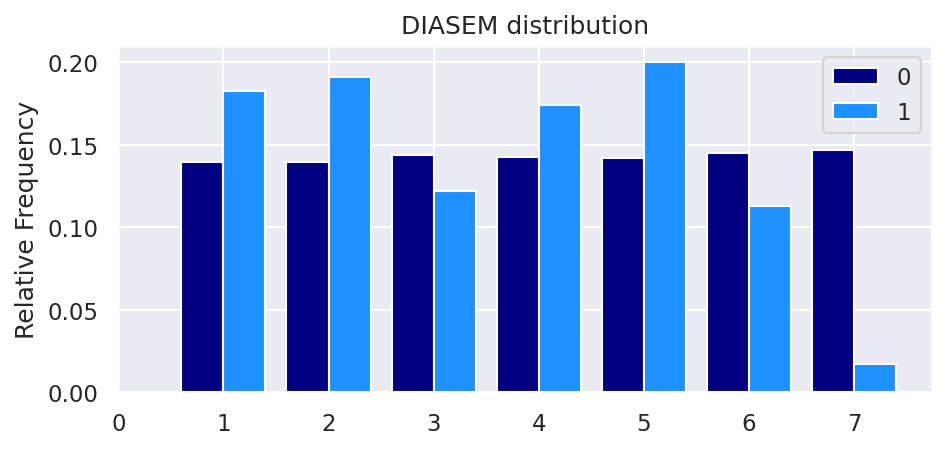

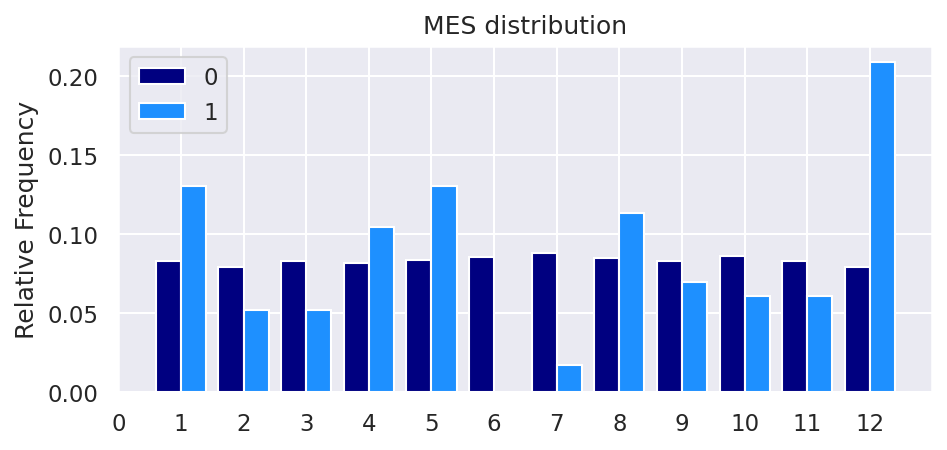

In [16]:
discrete = ["DIASEM", "MES"]
for variable in discrete:
    discrete_graph(df_aju_0, df_aju_1, variable)

Vemos que tanto el mes como el día de la semana parecen variables relevantes para predecir si un día es festivo o no.

**Respecto al día de la semana**:

Podríamos pensar que la relación existente entre el día de la semana se debe a que tenemos una muestra finita de datos, dado que cada año un día en concreto (por ejemplo el día de Navidad) se encuentra en el siguiente día de la semana (es decir, un año cae en lunes, al siguiente en martes, al siguiente en miércoles, etc). Sin embargo, si analizamos la cantidad de datos de los que disponemos:

In [17]:
len(df_aju)/365

7.887671232876713

Vemos que tenemos datos de prácticamente 8 años, por lo que esa diferencia entre días festivo por día de la semana no se debe a que tenemos datos de pocos años, sino a que realmente existe una relación. Por ejemplo, podemos ver que generalmente los festivos no caen en domingo, por que se suelen aplazar a otro día de la semana.

**Respecto al mes**:

Vemos que claramente hay meses que tienen más días festivos que otros, siendo Diciembre el mes con más días festivos del año, y Junio el que menos.

#### Variables cuantitativas continuas

Con el uso de la función que se muestra abajo procedemos a estudiar si existe alguna relación entre la variable de salida y las variables cuantitativas continuas de nuestro dataset.

In [18]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
def continous_graph(df, input, target): 
    sns.set(rc={'figure.figsize':(16,5)})
    fig, axs = plt.subplots(ncols=2)
    
    dens_plot = sns.histplot(data = df, x = input, hue=target, kde = True, palette=['royalblue', 'midnightblue'], ax=axs[0])
    axs[0].set_title('Distribution of the variable', fontdict={'fontsize':15})
    axs[0].axvline(x=df.loc[df[target] == 0][input].mean(), color='royalblue', ls='--')
    axs[0].axvline(x=df.loc[df[target] == 1][input].mean(), color='midnightblue', ls='--')

    boxplot = sns.boxplot(data=df , y=input, x=target, palette=['#6E91FF', '#00175F'], 
                          width=0.3, ax=axs[1], **{'medianprops':{'color':'gray'}})
    axs[1].set_ylabel(input, fontdict={'fontsize':15})   
    axs[1].set_title('Boxplot for each value of the target variable', fontdict={'fontsize':15})
    plt.show()
    return(dens_plot, boxplot)

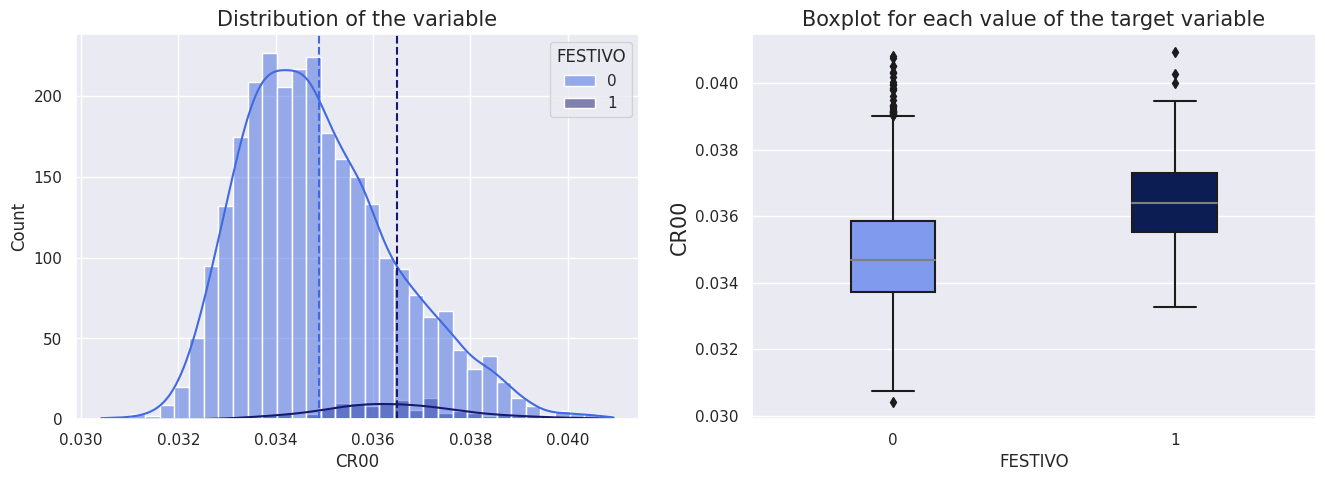

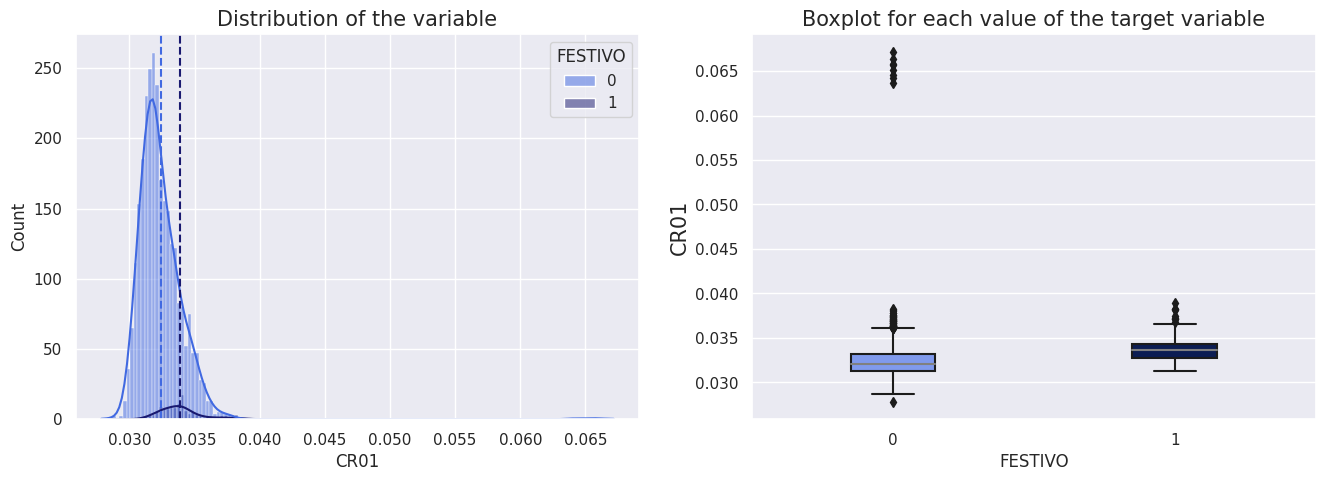

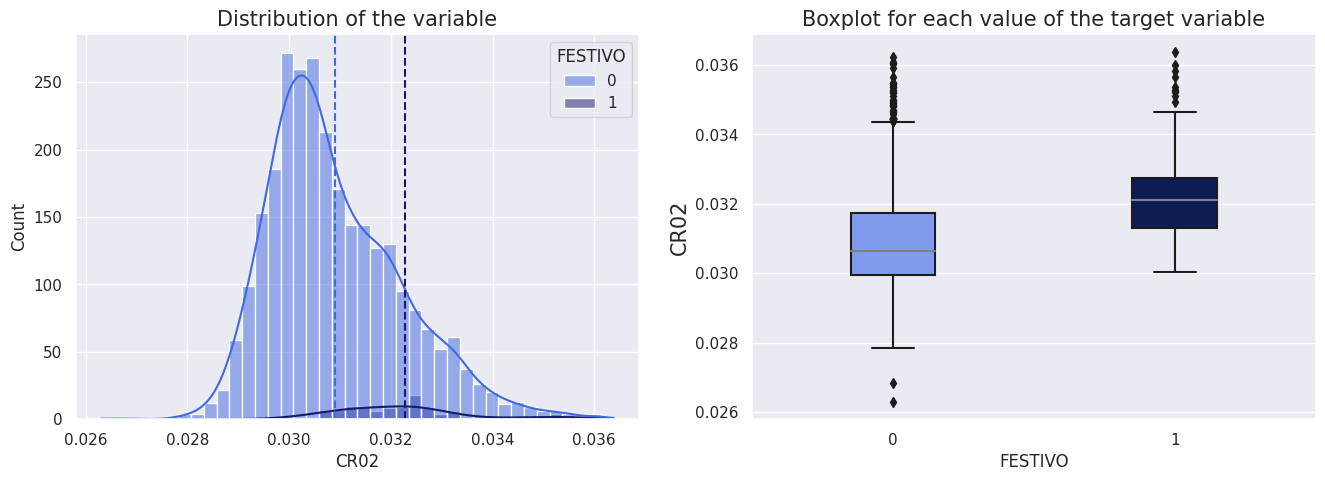

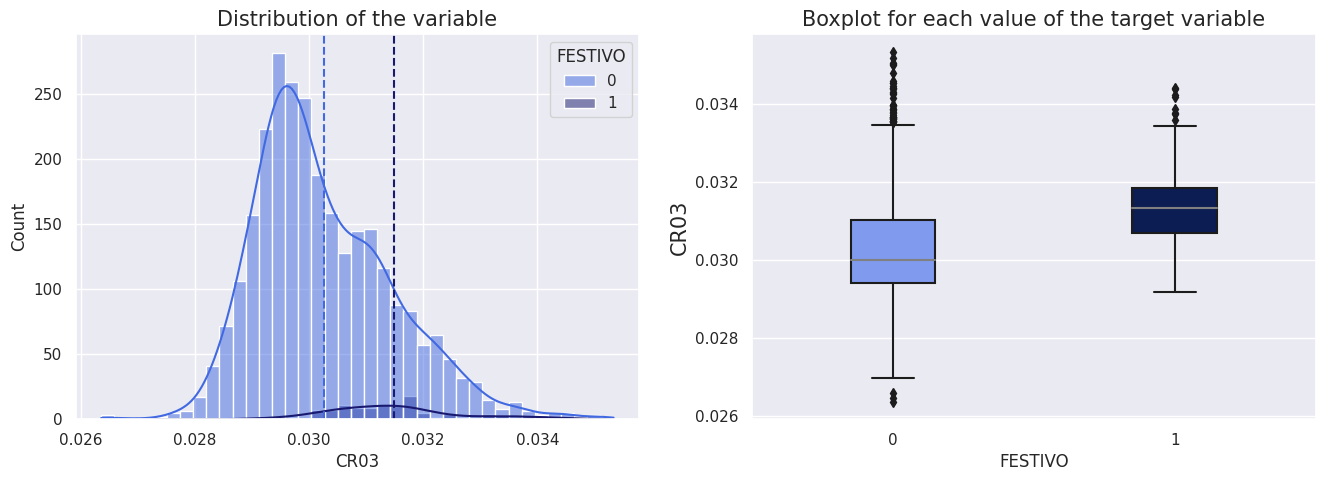

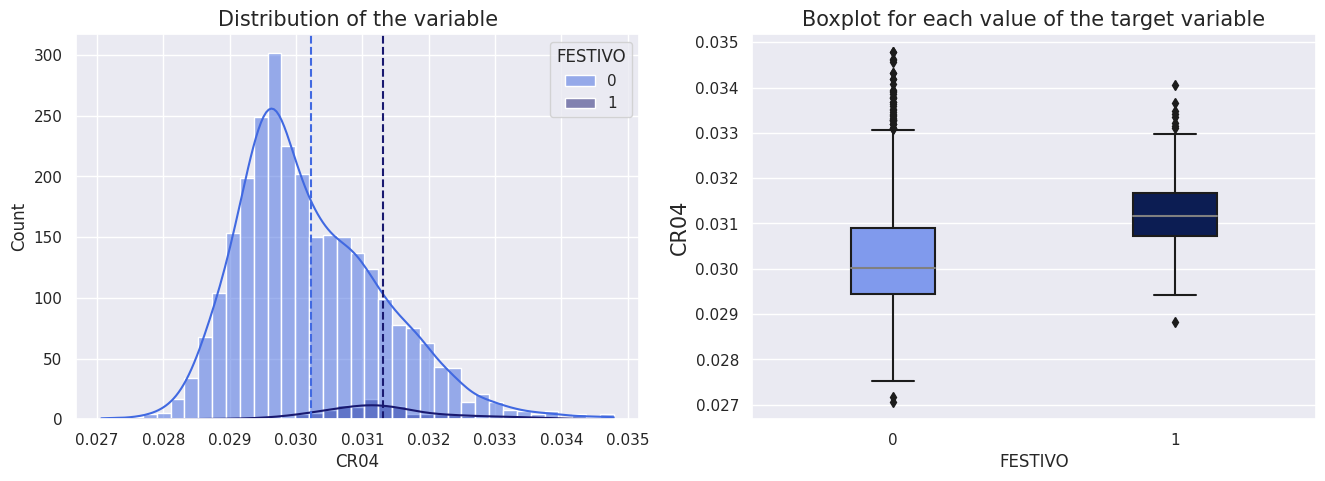

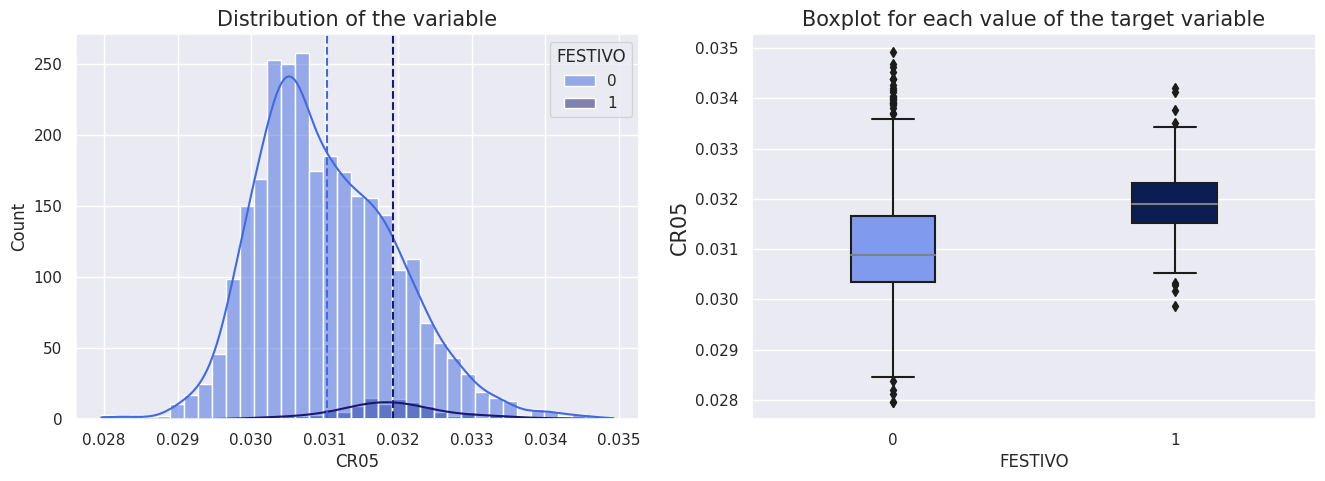

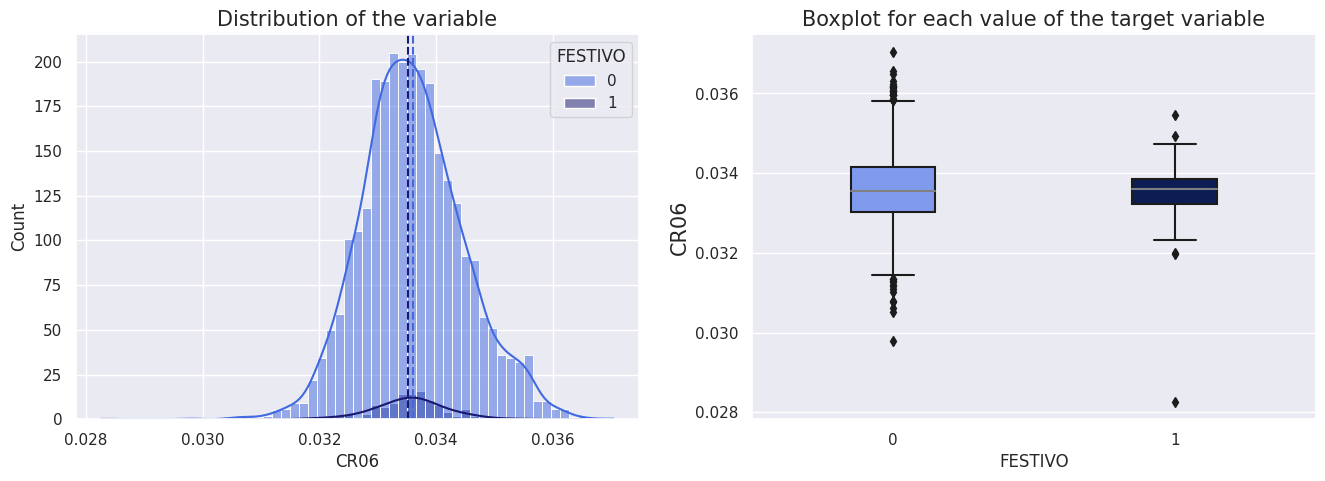

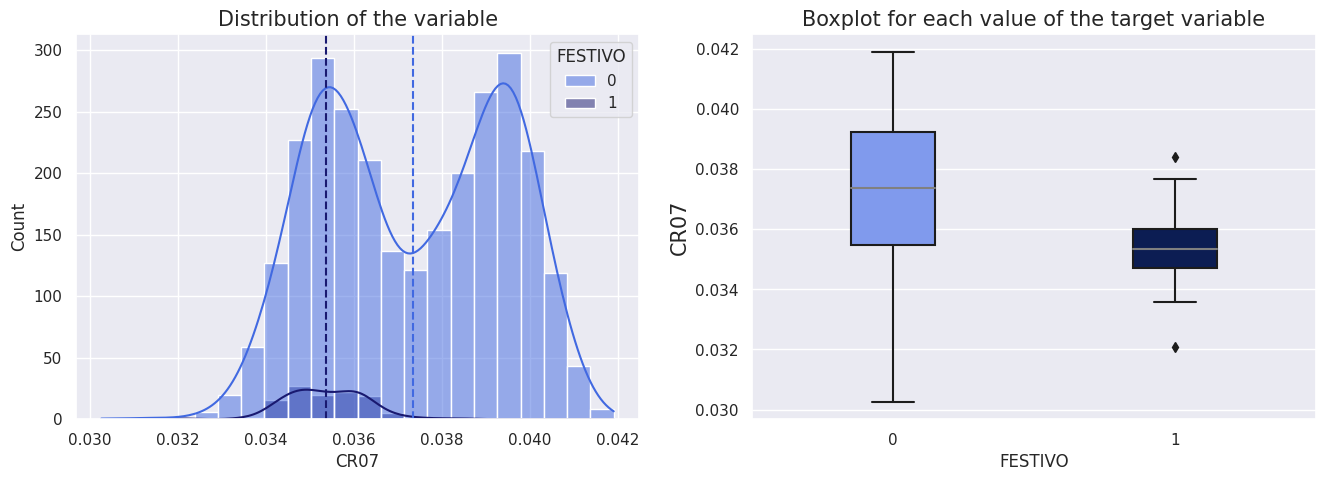

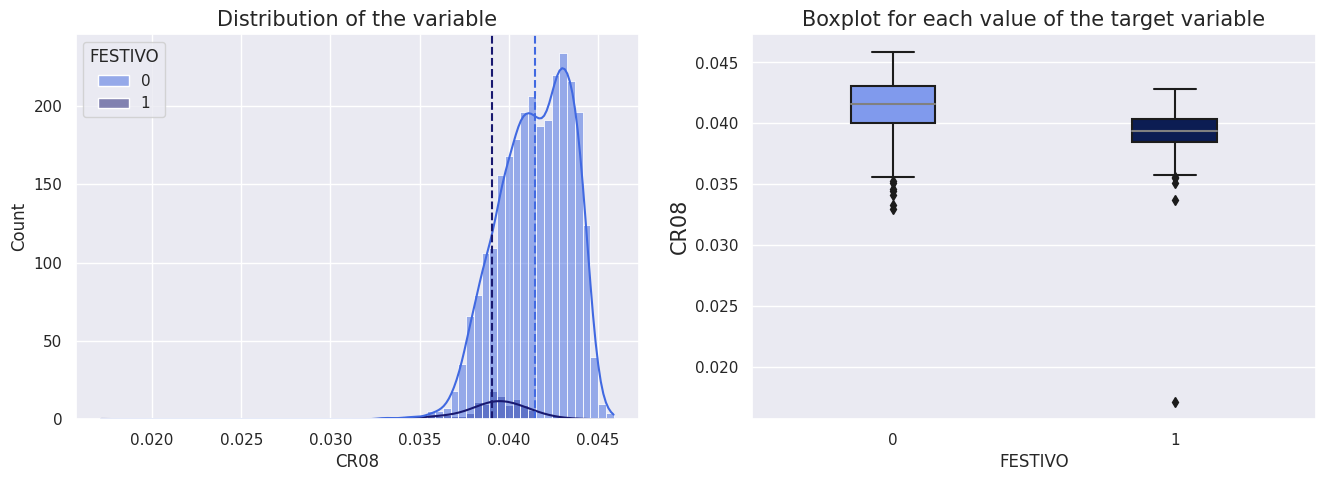

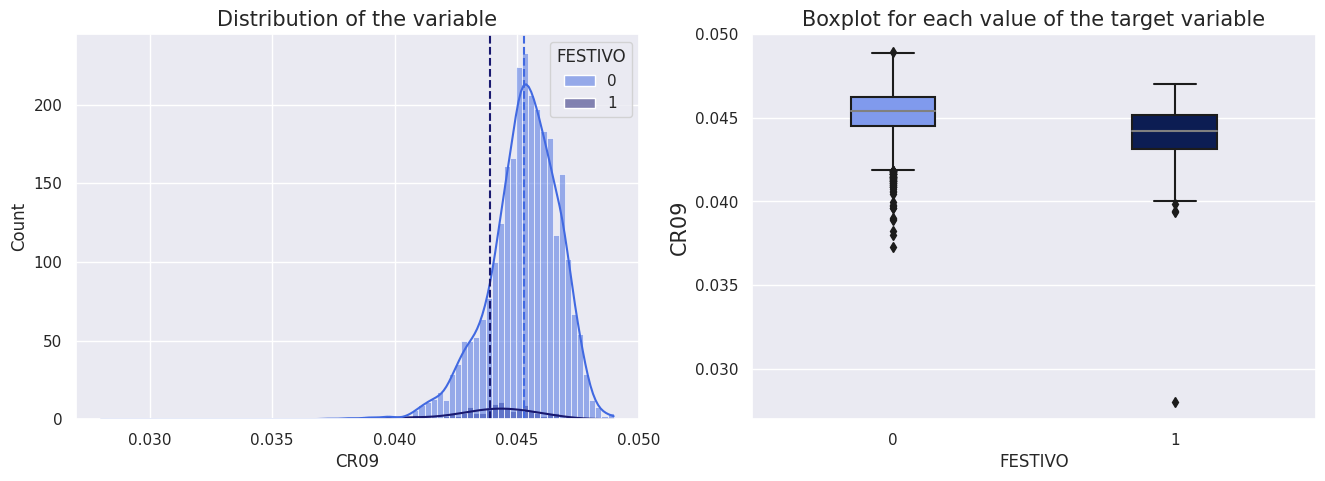

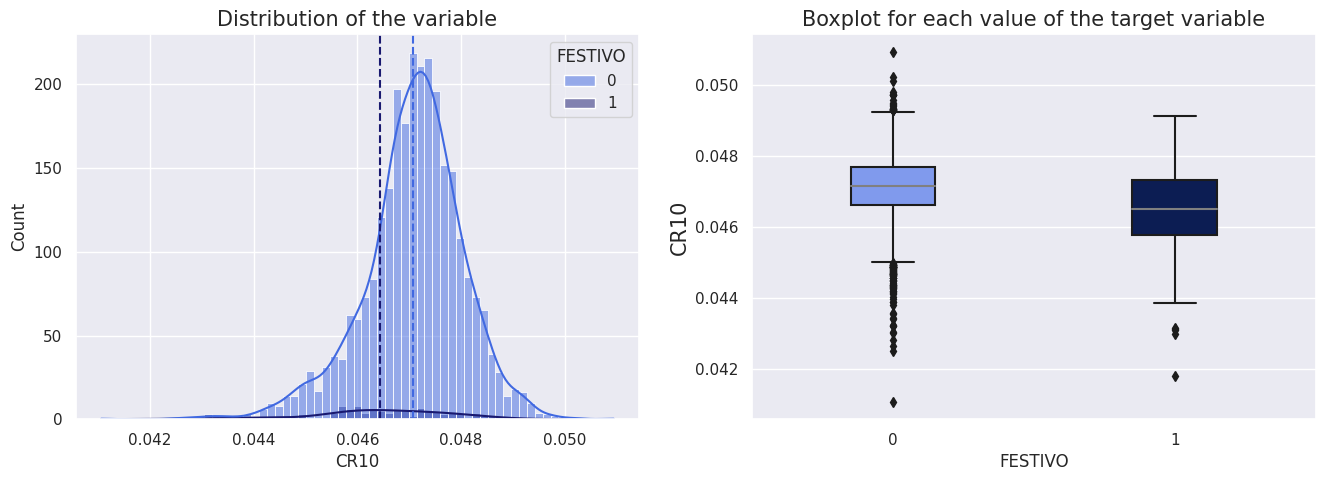

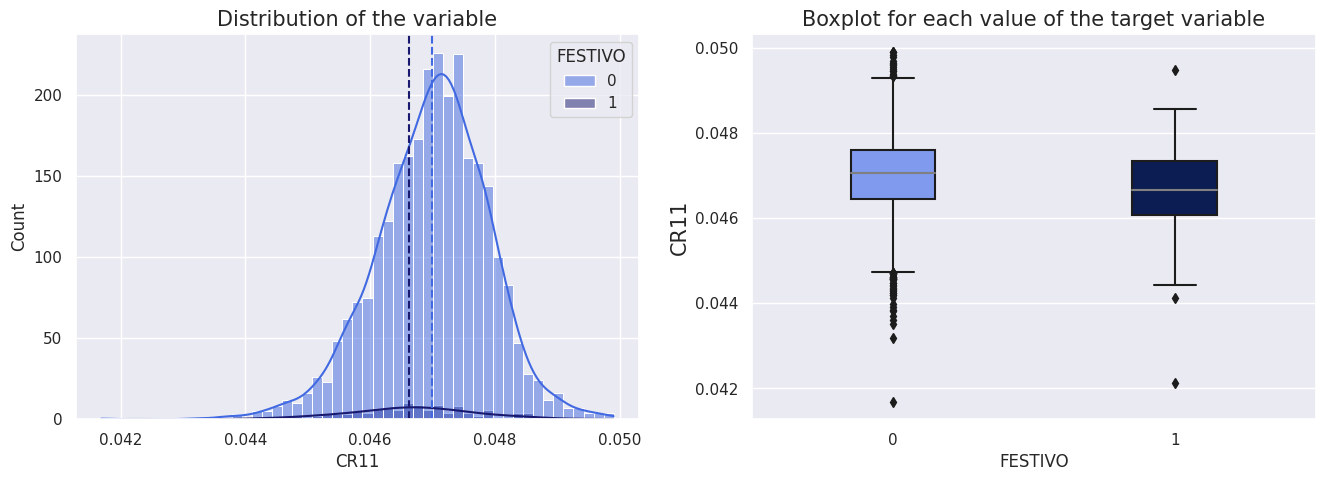

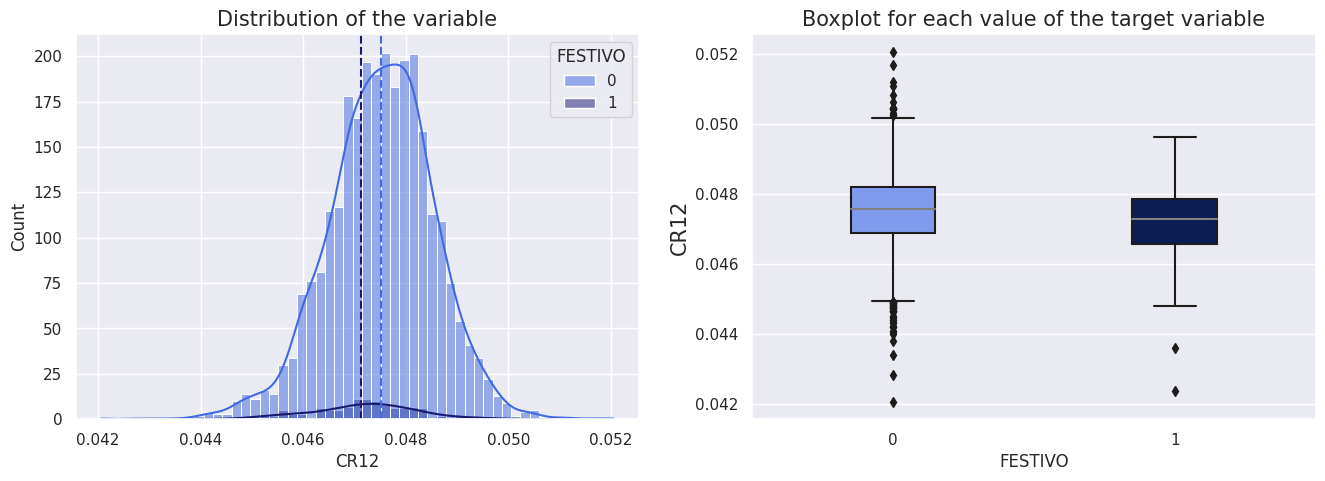

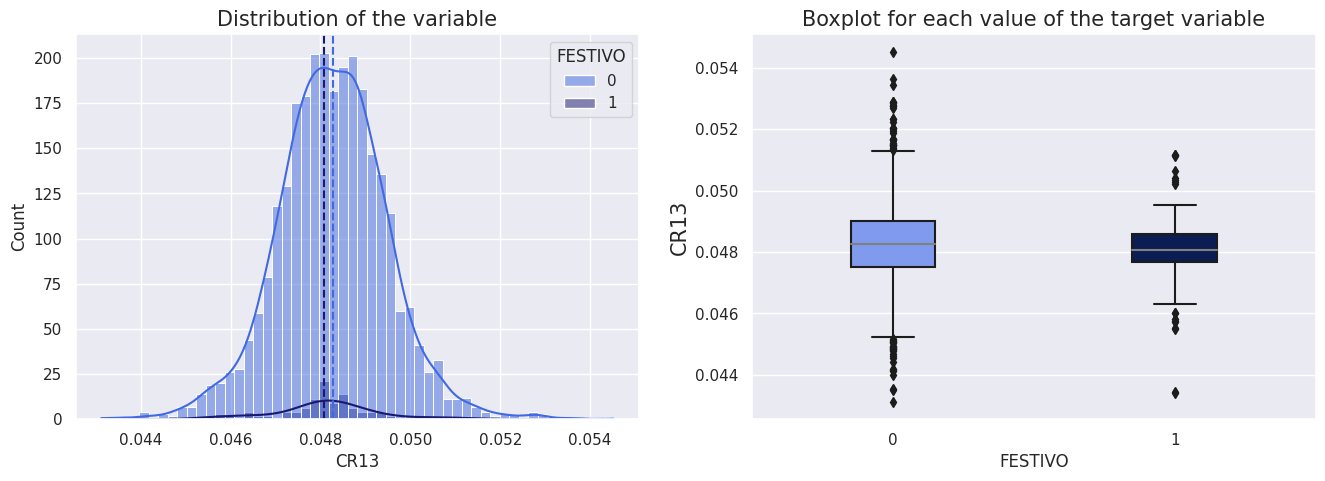

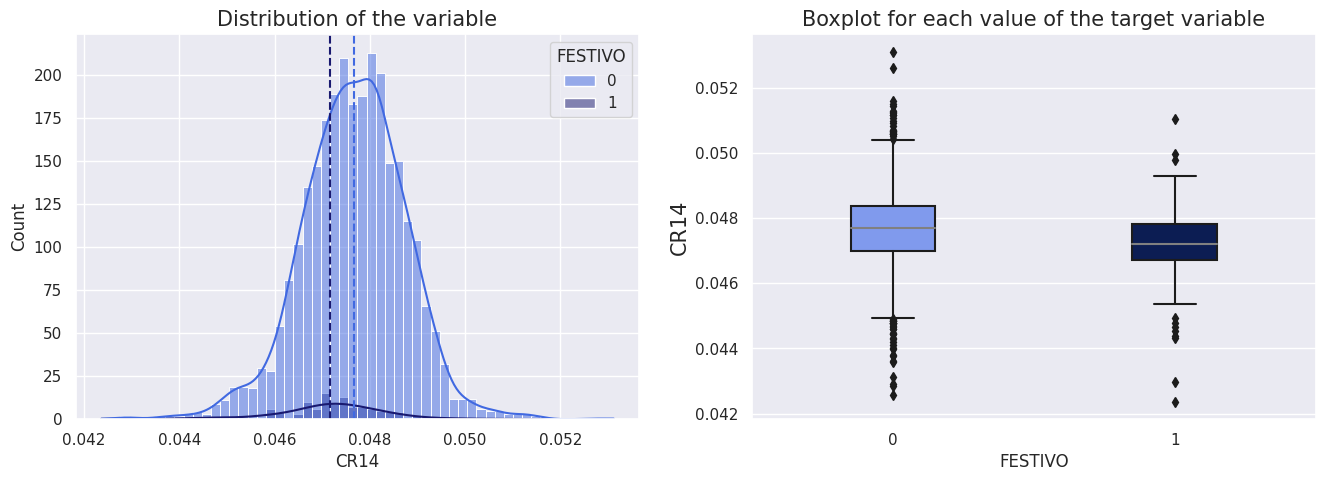

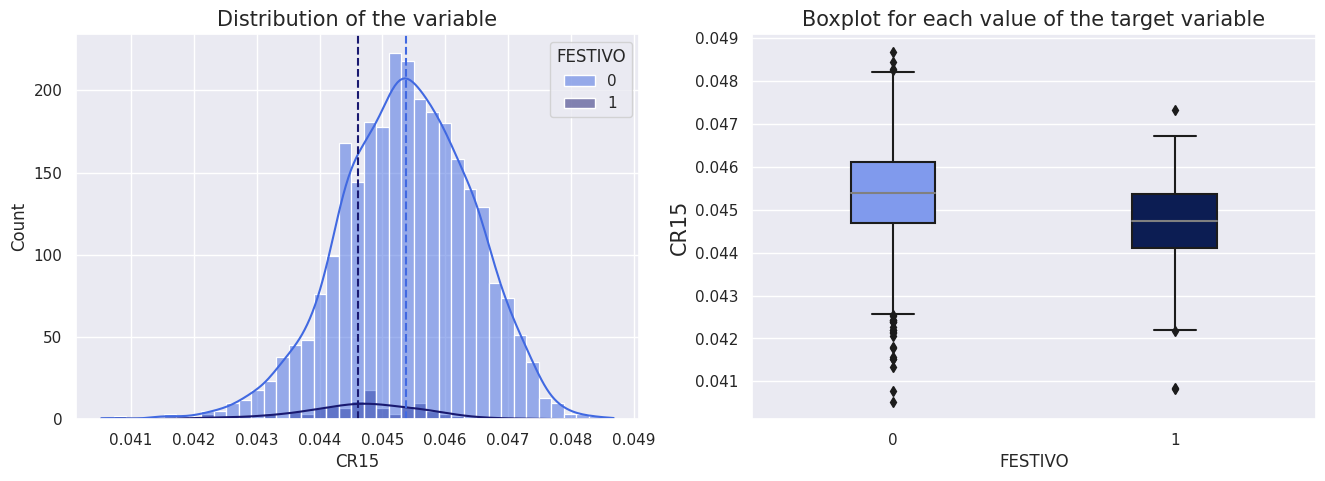

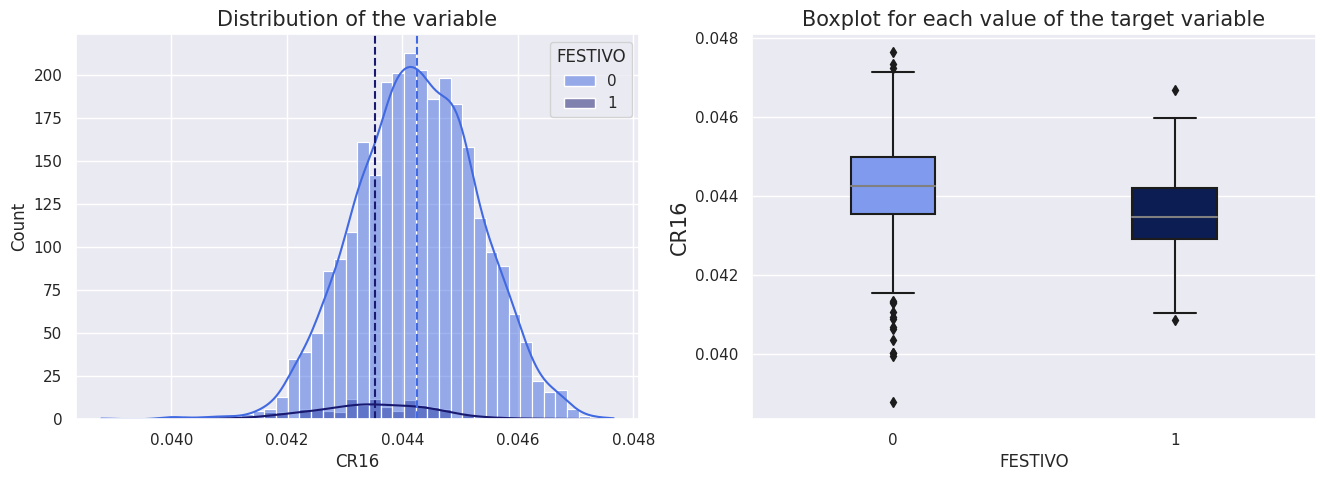

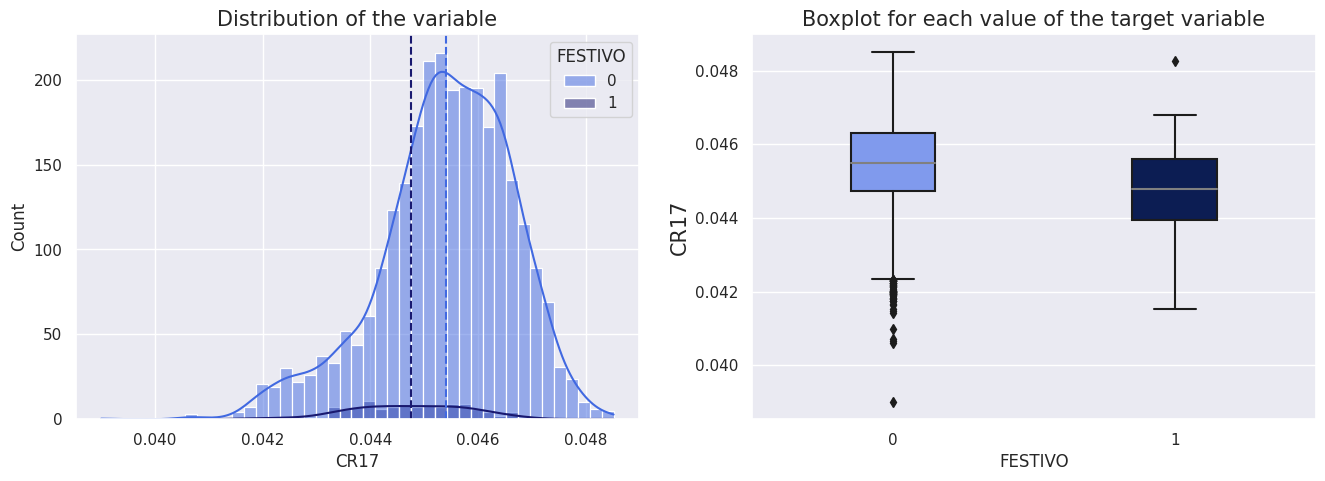

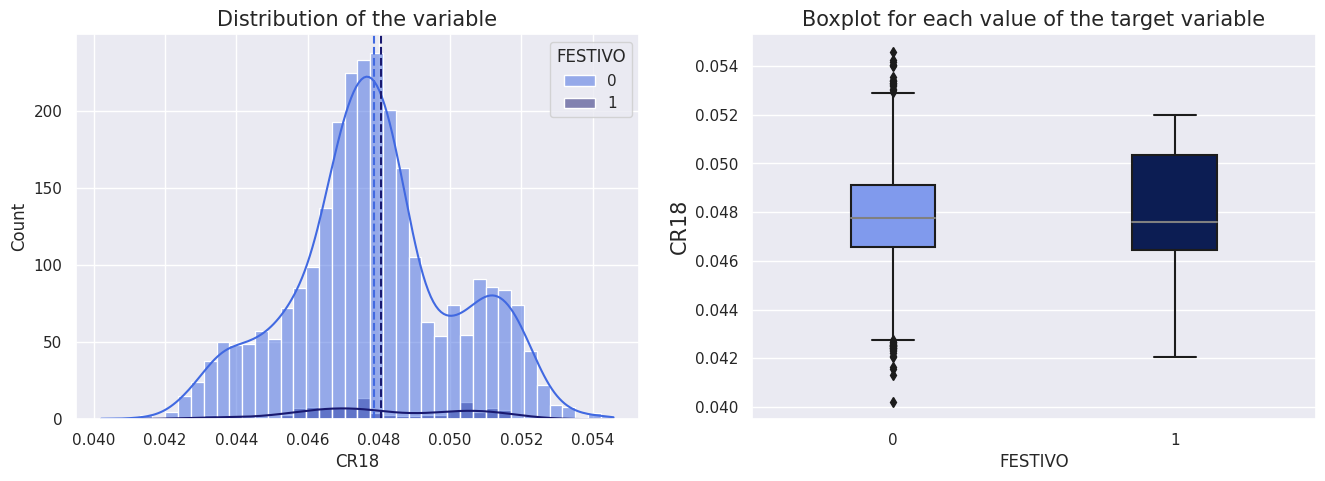

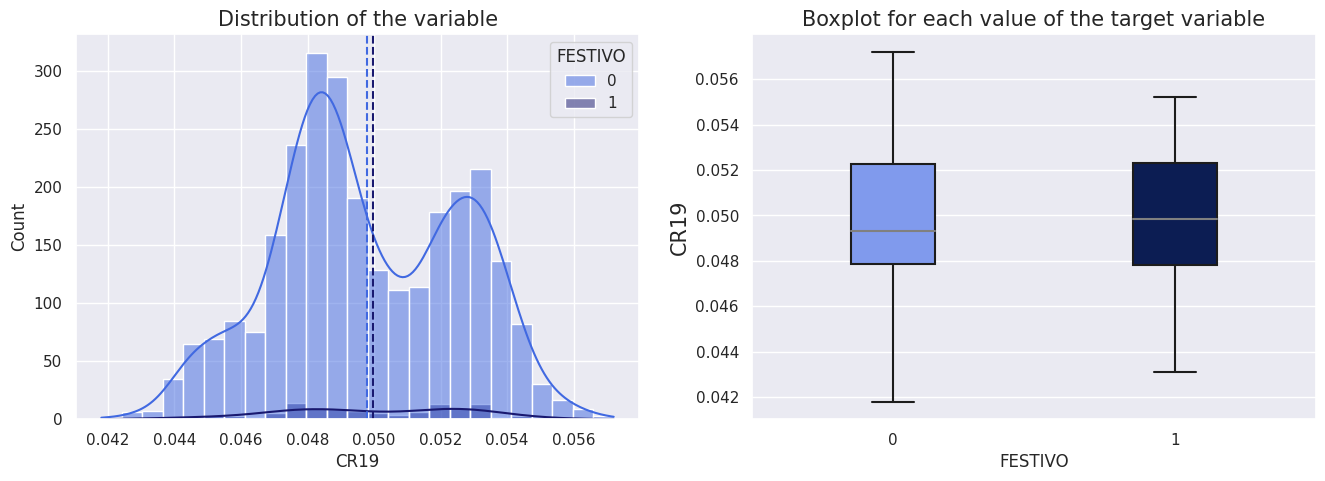

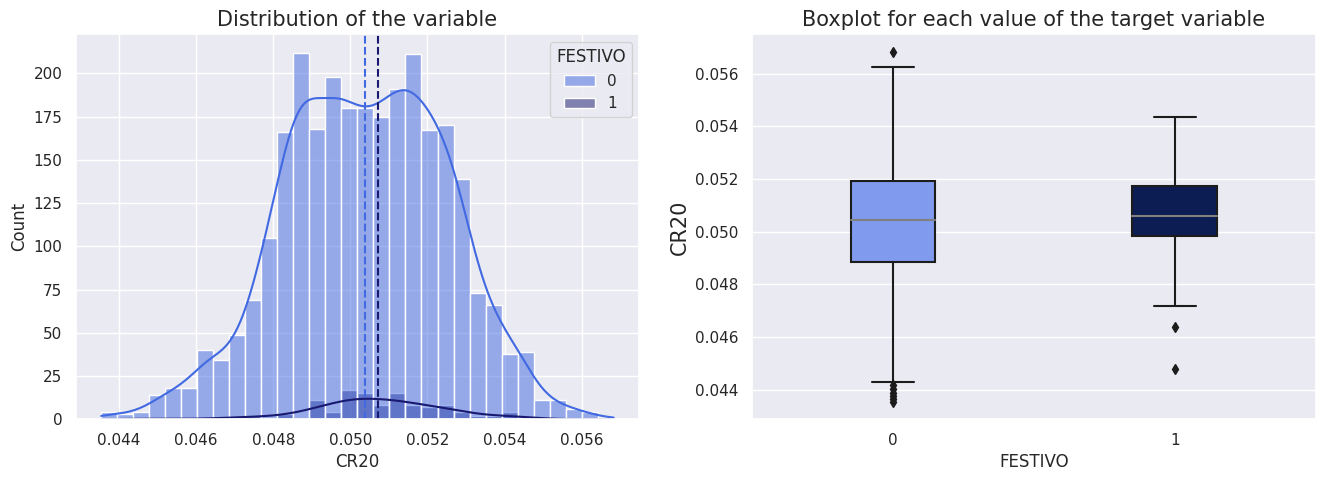

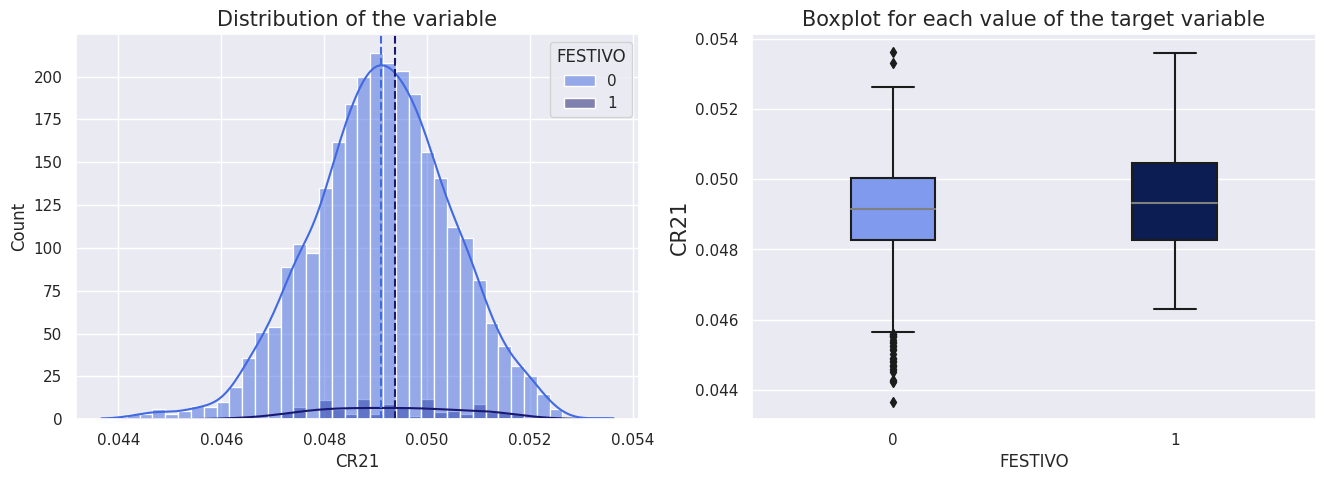

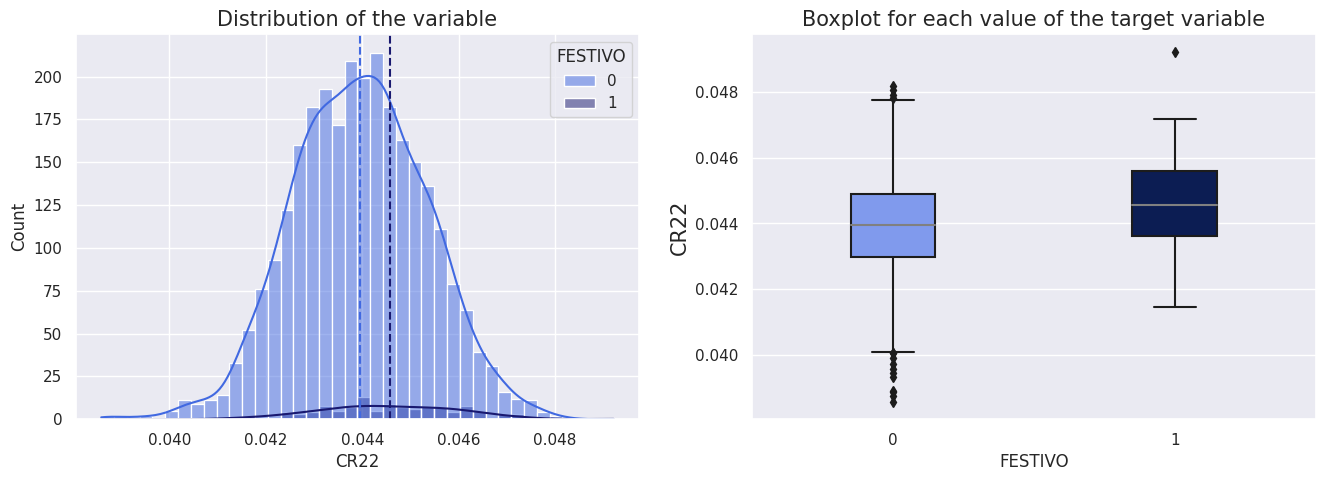

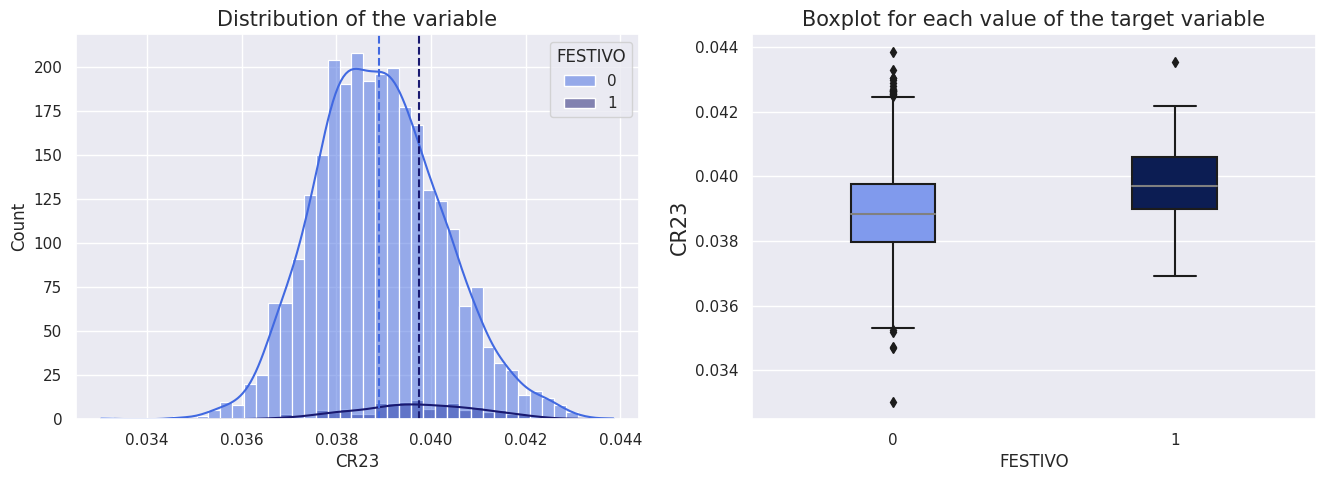

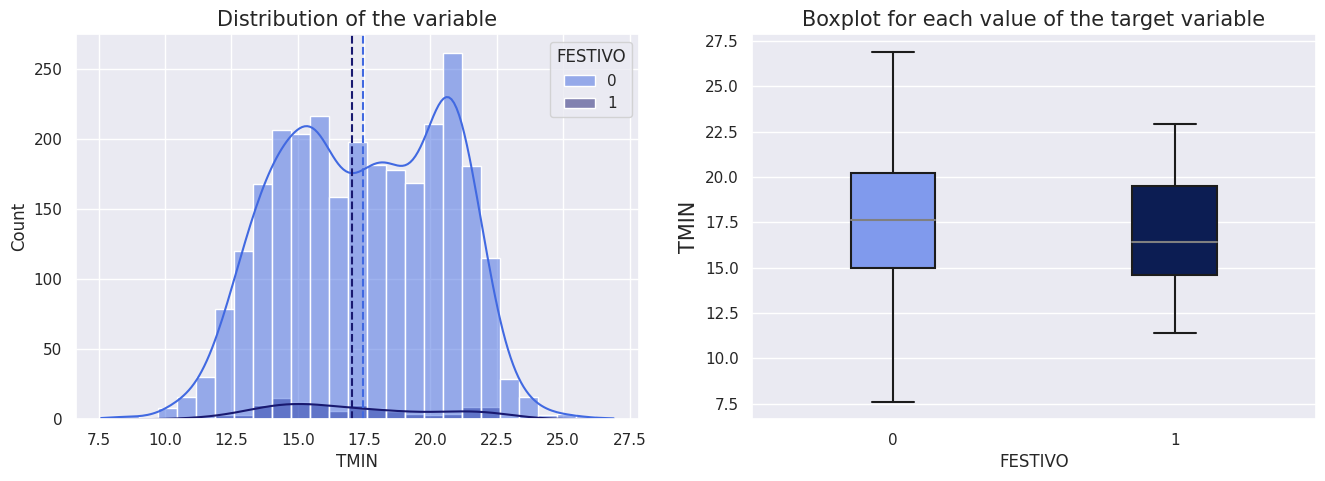

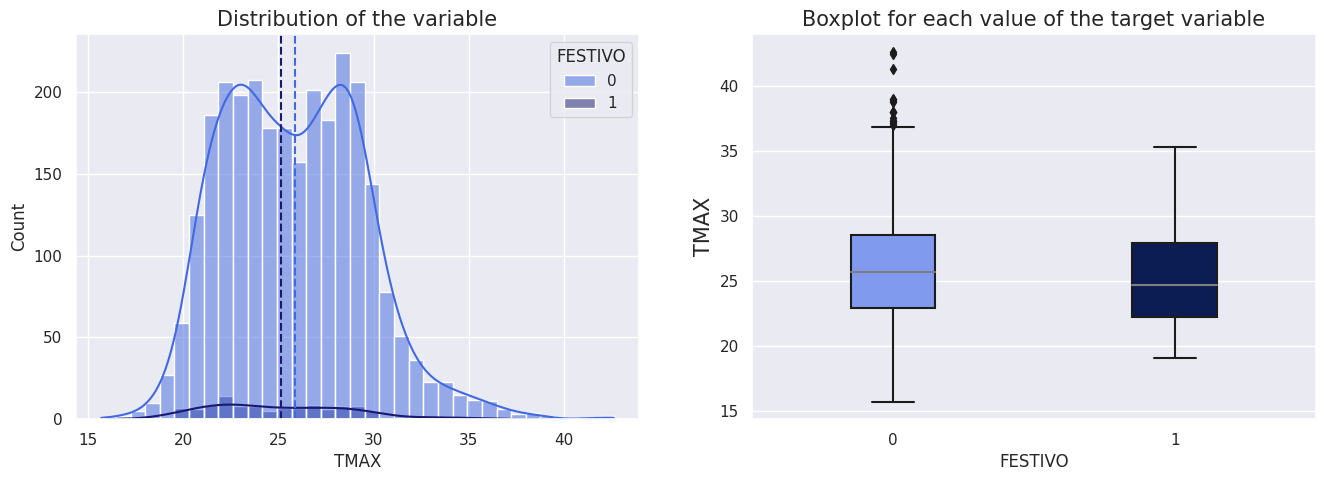

In [19]:
continuous = ['CR00','CR01','CR02','CR03','CR04','CR05','CR06','CR07','CR08','CR09','CR10','CR11','CR12','CR13',
              'CR14','CR15','CR16','CR17','CR18','CR19','CR20','CR21','CR22','CR23','TMIN','TMAX']
for variable in continuous:
    continous_graph(df_aju, variable, target)

Pese a que no se aprecia tan claramente la distribución correspondiente a los días festivos, gracias a los boxplots, así como a las medias de las distribuciones (líneas discontinuas verticales), podemos apreciar que no para todas las variables la media de ambas distribuciones son igual de parecidas. En consecuencia, podemos apreciar que algunas variables parecen ser más útiles de cara a discriminar días festivos de días no festivos, como por ejemplo:

- $CR00$
- $CR07$
- $CR08$

### Outliers

Vamos también a ver el porcentaje de outliers que tiene cada variable haciendo uso de la fórmula clásica para el cálculo de estos:

In [20]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
def detect_outliers(df, column_name):

    y = df.loc[:, column_name]
    iqr = stats.iqr(y)
    first_quantile, third_quantile = np.quantile(y, [0.25, 0.75])
    cut_low = first_quantile - 1.5 * iqr
    cut_high = third_quantile + 1.5 * iqr
    outliers = y.loc[(y < cut_low) | (y > cut_high)]
    return f"{column_name} : {np.round(100*outliers.count()/len(df), 1)}%", outliers.index

In [21]:
out_list = continuous
out=[]
for i in out_list:
    print(detect_outliers(df_aju, i)[0])
    if i not in ['TMIN','TMAX']:
        out.extend(detect_outliers(df_aju, i)[1].values)

CR00 : 0.9%
CR01 : 1.7%
CR02 : 1.6%
CR03 : 1.6%
CR04 : 1.4%
CR05 : 1.0%
CR06 : 1.4%
CR07 : 0.0%
CR08 : 0.3%
CR09 : 2.4%
CR10 : 3.9%
CR11 : 1.9%
CR12 : 1.8%
CR13 : 2.3%
CR14 : 2.2%
CR15 : 1.0%
CR16 : 0.6%
CR17 : 2.0%
CR18 : 1.3%
CR19 : 0.0%
CR20 : 0.3%
CR21 : 1.1%
CR22 : 0.6%
CR23 : 0.7%
TMIN : 0.0%
TMAX : 0.5%


Vemos que en ningún caso se supera el porcentaje de crítico del $5\%$ que típicamente se toma como umbral para determinar si el porcentaje de outliers es excesivo. Vemos adicionalmente que en algunos casos este porcentaje es mayor que en otros, como por ejemplo de la variable explicativa $CR10$ donde el porcentaje es prácticamente del $4\%$.

In [22]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
festivos=df_aju_1.index
out=pd.Series(out)
print("Numero de festivos en los datos: ",len(festivos))
print("Numero de fechas que tienen al menos un outlier de demanda iqr en sus horas: ",len(out.value_counts().index))
print("Numero de outliers coincidentes con festivos: ",len(out.value_counts().index.intersection(festivos)))
df_aju.reset_index(inplace=True)
df_aju['FECHA']=df_aju['FECHA'].astype(str)

Numero de festivos en los datos:  115
Numero de fechas que tienen al menos un outlier de demanda iqr en sus horas:  365
Numero de outliers coincidentes con festivos:  23


#### Prepara los conjuntos de entrenamiento y test

- Divide los datos disponibles de ajuste (df_aju) en dos conjuntos diferentes (TR:80% y TS: 20%). TS lo deberías de utilizar para validar la calidad de los diferentes modelos que se creen.
- Recuerda fijar una semilla para garantizar que la separación es reproducible

Es importante en los problemas de clasificación asegurarse de que el porcentaje de datos que pertenece a cada clase es el mismo en ambos datasets (train y test), de forma que que ambos datasets son representativos de la población de salida. Para ello, usaremos la clase `StratifiedShuffleSplit` de `scikit-learn`. De esta forma, la frecuencia relativa de la variable de salida es la misma en ambos sets.

In [23]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

# Crea dos dataframes df_aju_tr y df_aju_ts y trabaja con ellos

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2023)
for train_index, test_index in split.split(df_aju, df_aju[target]):
    df_aju_tr = df_aju.loc[train_index]
    df_aju_ts = df_aju.loc[test_index]

Tras dividir los datos en training y test vamos a comprobar que efectivamente la frecuencia relativa de las dos clases de la variable de salida es prácticamente idéntico en ambos casos.

In [24]:
df_aju_tr[target].value_counts(normalize=True).sort_index()

0    0.960052
1    0.039948
Name: FESTIVO, dtype: float64

In [25]:
df_aju_ts[target].value_counts(normalize=True).sort_index()

0    0.960069
1    0.039931
Name: FESTIVO, dtype: float64

Vemos que efectivamente esa condición se cumple. Adicionalmente, podemos comprobar que las clases están totalmente desbalanceadas, lo cual se debe a que hay muchos más días festivos que no festivos. Si comprobamos visualmente el balanceo de clases existente:

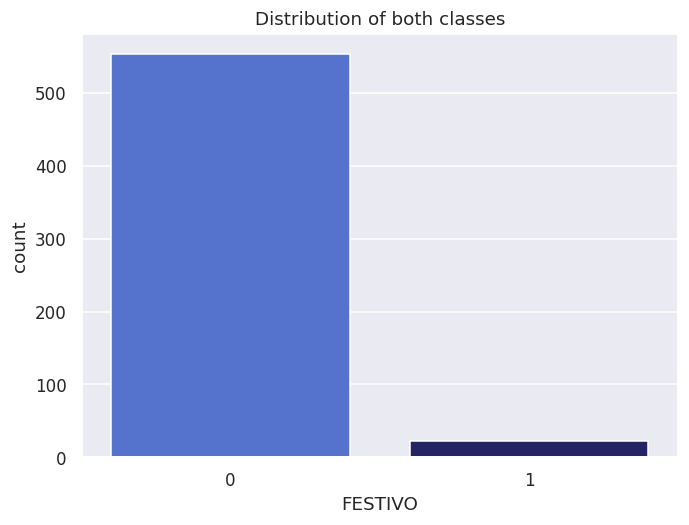

In [26]:
plt.figure(figsize=(7,5), dpi=110)
sns.countplot(x=df_aju_ts[target], palette=['royalblue', 'midnightblue'])
plt.title('Distribution of both classes')
plt.show()

El desbalanceo de clases genera que los modelos sufran de overfitting. Esto es muy común en problemas como por ejemplo la detección de fraude, donde se disponen de mucho más datos de la clase negativa que de la clase positiva. Por ello, para obtener un modelo que produzca buenos resultados, tenemos que aplicar técnicas de upsampling, como es el caso de `SMOTE`, las cuales nos permite aumentar el tamaño de observaciones correspondientes a la clase positiva. Más adelante se explicará en detalle la técnica usada para corregir el desbalanceo de clases, así como el código asociado a ello.

### Pipeline

Vamos a definir el Pipeline de procesado de datos, el cual nos servirá tanto para el training set como para el test set:

In [27]:
numeric_columns = continuous
categorical_columns = discrete
attributes = numeric_columns + categorical_columns
attributes

['CR00',
 'CR01',
 'CR02',
 'CR03',
 'CR04',
 'CR05',
 'CR06',
 'CR07',
 'CR08',
 'CR09',
 'CR10',
 'CR11',
 'CR12',
 'CR13',
 'CR14',
 'CR15',
 'CR16',
 'CR17',
 'CR18',
 'CR19',
 'CR20',
 'CR21',
 'CR22',
 'CR23',
 'TMIN',
 'TMAX',
 'DIASEM',
 'MES']

Definimos el Pipeline:

In [28]:
std_scaler = StandardScaler()
one_hot = OneHotEncoder(handle_unknown='ignore', drop='first')

In [29]:
# Define individual Pipelines
# 1. Numeric
numeric_pipeline = Pipeline([
    ('std_scaler', std_scaler),
    ])
# 2. Categorical
categorical_pipeline = Pipeline([
    ('one_hot', one_hot)
    ])

In [30]:
# Define Full Pipeline
full_pipeline = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_columns),
    ('categorical', categorical_pipeline, categorical_columns)
])

Aplicamos el Pipeline sobre el dataset de entrenamiento:

In [31]:
# Get the attributes we're interested in
train_to_pipeline = df_aju_tr.loc[:, attributes]
# Apply the transformations
train_tr = full_pipeline.fit_transform(train_to_pipeline)
columns = full_pipeline.get_feature_names_out(attributes).tolist()
columns = [col.split("__")[-1] for col in columns]
train_tr = pd.DataFrame(train_tr, columns=columns, index=df_aju_tr.index)
# Check the result
train_tr.head()

CR00      CR01      CR02      CR03      CR04      CR05      CR06  \
1952  1.260620  0.840060  1.256808  1.254556  1.177775  1.273398 -0.607102   
867   1.979130  1.076802  1.544708  1.551933  1.362950  1.146030 -0.087718   
920   0.400844 -0.043932 -0.156253 -0.375729 -0.534319 -0.652836 -1.259200   
2625  0.401176  0.319584  0.776867  1.049959  1.185049  1.543243  3.166940   
110  -0.041790 -0.340944 -0.434710 -0.552819 -0.357232 -0.314428  0.416619   

          CR07      CR08      CR09      CR10      CR11      CR12      CR13  \
1952 -1.300114 -1.326258 -1.464415 -1.317827 -0.476111 -0.671572 -0.385874   
867  -1.391622 -1.173894 -1.106891 -1.257942 -0.573893 -0.092207 -0.238981   
920  -0.970462 -0.745990 -0.971855 -1.082277 -1.319322 -0.090163  0.854643   
2625  1.747399  1.069887  0.713100  0.535377  0.596710  0.759972  0.274569   
110   0.851661  0.419652 -0.020352 -0.123040 -0.203892 -0.415075 -1.100732   

          CR14      CR15      CR16      CR17      CR18      CR19      CR20  \
1952 -0.756295 -0.949312 -0.498416  1.005680  0.161977 -0.383408 -0.465072   
867  -0.127680 -0.121233 -0.329764 -0.267640 -0.690048 -0.945220 -1.245433   
920   1.316271  1.981976  2.403357  1.788500  0.363447 -0.183306 -0.959068   
2625 -0.747176 -0.906941 -1.173299 -1.669594 -1.691954 -1.767388 -1.496223   
110  -0.437724 -0.235252 -0.102054 -0.323254 -0.452030 -0.659298  0.111060   

          CR21      CR22      CR23      TMIN      TMAX  DIASEM_2  DIASEM_3  \
1952  1.232740  1.040251  0.800751  1.113249  2.511752       0.0       0.0   
867   0.459735  1.263953  1.881582 -0.089031  0.065744       0.0       0.0   
920   0.079709  0.547272  0.865637  1.210731  1.261570       0.0       0.0   
2625 -0.775390 -0.259226  0.249131 -0.056537 -0.124501       0.0       0.0   
110   2.296877  1.375521  0.630672 -0.219007 -0.042968       0.0       0.0   

      DIASEM_4  DIASEM_5  DIASEM_6  DIASEM_7  MES_2  MES_3  MES_4  MES_5  \
1952       0.0       0.0       0.0       1.0    0.0    0.0    0.0    0.0   
867        0.0       0.0       0.0       1.0    0.0    0.0    0.0    1.0   
920        0.0       1.0       0.0       0.0    0.0    0.0    0.0    0.0   
2625       0.0       1.0       0.0       0.0    0.0    0.0    1.0    0.0   
110        1.0       0.0       0.0       0.0    0.0    0.0    1.0    0.0   

      MES_6  MES_7  MES_8  MES_9  MES_10  MES_11  MES_12  
1952    1.0    0.0    0.0    0.0     0.0     0.0     0.0  
867     0.0    0.0    0.0    0.0     0.0     0.0     0.0  
920     0.0    1.0    0.0    0.0     0.0     0.0     0.0  
2625    0.0    0.0    0.0    0.0     0.0     0.0     0.0  
110     0.0    0.0    0.0    0.0     0.0     0.0     0.0

Finalmente obtenemos $X_{train}$ y $y_{train}$:

In [32]:
X_train = train_tr.copy()
y_train = df_aju_tr[target]

### Desbalanceo de clases

Cómo resolver el desequilibrio de clases

Existen dos posibilidades para solucionar el problema del desequilibrio de clases:

- Reducir los datos de la clase más grande, también conocido como ***downsampling***. Esta opción funciona bien cuando se tiene una gran cantidad de datos ya que aún se cuenta con un número significativo de instancias en cada clase luego de eliminar los datos de la clase más grande. Sin embargo, en este caso no es la mejor opción, ya que no se dispone de una cantidad de datos excesiva (y muy pocos datos de la clase minoritaria).

- Crear datos sintéticos para la clase más pequeña, conocido como ***upsampling***. Con esta técnica, la clase más pequeña tendrá el mismo número de instancias que la clase más grande.

En este caso, el submuestreo no es la mejor opción debido a la falta de datos, por lo que utilizaremos la técnica de ***downsampling***, específicamente la técnica SMOTE. Esta técnica funciona de la siguiente manera:

1. Se toma una muestra aleatoria de la clase más pequeña.
2. Se buscan los $k$ vecinos más cercanos a esa muestra.
3. Se elige al azar una instancia de esos $k$ vecinos más cercanos.
4. Se obtiene un vector entre la muestra aleatoria y el vecino seleccionado anteriormente.
5. Se multiplica ese vector por un número aleatorio entre $0$ y $1$.
6. Se obtiene una nueva muestra sintética.

Este proceso se repite $n$ veces hasta que la clase más pequeña tenga el mismo número de instancias que la clase más grande. En algunos casos, combinar ambas técnicas, submuestreo y sobremuestreo, puede dar mejores resultados, especialmente si utilizar solo sobremuestreo resulta en una cantidad mayor de datos sintéticos que reales en la clase minoritaria, lo que podría generar un gran sesgo en el modelo.

Por lo tanto, aplicaremos la técnica SMOTE al conjunto de entrenamiento:

In [33]:
SMOTE_ = SMOTE(random_state=2023)
X_train, y_train = SMOTE_.fit_resample(X_train, y_train)

Comprobamos que tras aplicar `SMOTE` ambas clases están balanceadas:

In [34]:
y_train.value_counts(normalize=True).sort_index()

0    0.5
1    0.5
Name: FESTIVO, dtype: float64

Generamos de nuevo el mismo histograma que en caso anterior, de forma que se aprecia visualmente la diferencia tras haber aplicado `SMOTE`:

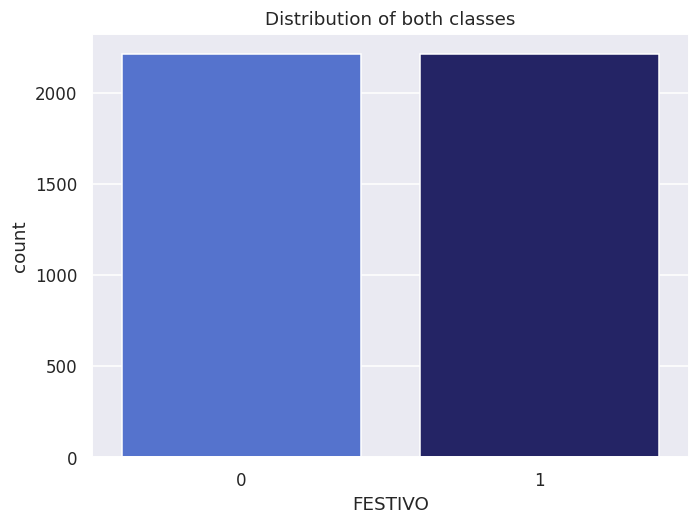

In [35]:
plt.figure(figsize=(7,5), dpi=110)
sns.countplot(x=y_train, palette=['royalblue', 'midnightblue'])
plt.title('Distribution of both classes')
plt.show()

Se puede apreciar que ahora se tiene el mismo número de observaciones de ambas clases.

A continuación aplicamos las mismas transformaciones que aplicamos en el Pipeline al dataset de test.

In [36]:
# Get the attributes we're interested in
test_to_pipeline = df_aju_ts.loc[:, attributes]
# Apply the transformations
test_tr = full_pipeline.transform(test_to_pipeline)
test_tr = pd.DataFrame(test_tr, columns=columns, index=df_aju_ts.index)
# Check the result
test_tr.head()

CR00      CR01      CR02      CR03      CR04      CR05      CR06  \
139   0.962051  0.694993  0.835203  0.966244  0.827941  0.936723 -0.232629   
1371  0.486880  0.142927  0.211116  0.230165  0.192324  0.102861 -0.800682   
984   0.494631  0.305878  0.602950  0.480042  0.466479  0.489823 -0.527704   
2660  0.314115  0.411898  0.716906  1.092873  1.042821  1.250062  2.156379   
2437  2.205074  1.781726  2.616072  2.730372  2.745224  2.625796  1.188138   

          CR07      CR08      CR09      CR10      CR11      CR12      CR13  \
139  -1.320206 -1.034886 -0.119785  1.214670  1.796358  1.616485  1.215648   
1371 -0.278844 -0.470154  0.557020  0.965996  1.169250  0.709468  0.225697   
984  -0.809990 -0.875445 -0.254074  0.578744  0.644214  0.450817  0.372039   
2660  1.255250  0.849776  0.230605 -0.126044  0.824117  1.819163  0.807679   
2437 -0.625514 -1.827572 -1.999935 -0.969032  0.560038  1.149231  0.393526   

          CR14      CR15      CR16      CR17      CR18      CR19      CR20  \
139   0.623004  0.101568 -0.986295 -1.015749 -0.764630 -1.037853 -1.625560   
1371 -0.501650 -0.660198 -0.118167 -0.196035 -0.472071  0.102282  0.350450   
984   0.042964  0.010918  0.333211  0.303760 -0.278587 -0.553229  0.082627   
2660  0.703852  0.582676  0.100885 -0.840100 -1.572701 -1.918428 -2.290811   
2437 -0.550654 -1.073934 -1.707760 -2.179907 -1.781437 -1.301160  0.360599   

          CR21      CR22      CR23      TMIN      TMAX  DIASEM_2  DIASEM_3  \
139  -0.766747  0.483242  1.547206  0.300898 -0.423458       0.0       0.0   
1371 -0.592322 -0.621364 -0.188407  1.015767  0.310345       0.0       0.0   
984  -0.901424 -0.061734  0.665596  0.950779  0.582123       0.0       0.0   
2660 -1.365547 -0.549809 -0.066334  0.625838  1.315926       0.0       0.0   
2437 -0.487342 -0.288327  0.181026  0.788308  0.337522       0.0       0.0   

      DIASEM_4  DIASEM_5  DIASEM_6  DIASEM_7  MES_2  MES_3  MES_4  MES_5  \
139        0.0       0.0       1.0       0.0    0.0    0.0    0.0    1.0   
1371       0.0       0.0       1.0       0.0    0.0    0.0    0.0    0.0   
984        0.0       0.0       1.0       0.0    0.0    0.0    0.0    0.0   
2660       0.0       1.0       0.0       0.0    0.0    0.0    0.0    1.0   
2437       0.0       0.0       0.0       1.0    0.0    0.0    0.0    0.0   

      MES_6  MES_7  MES_8  MES_9  MES_10  MES_11  MES_12  
139     0.0    0.0    0.0    0.0     0.0     0.0     0.0  
1371    0.0    0.0    0.0    0.0     1.0     0.0     0.0  
984     0.0    0.0    0.0    1.0     0.0     0.0     0.0  
2660    0.0    0.0    0.0    0.0     0.0     0.0     0.0  
2437    0.0    0.0    0.0    0.0     1.0     0.0     0.0

Tras ello obtenemo $X_{test}$ y $y_{test}$:

In [37]:
X_test = test_tr.copy()
y_test = df_aju_ts[target]

Finalmente, para ver el performance el cada modelo, definimos la siguiente función que nos permite reutilizar código:

In [38]:
def metrics_summary(model, X, Y, threshold=0.5):
    predictions_proba = model.predict_proba(X)[:, 1]
    predictions = np.array([1 if i>threshold else 0 for i in predictions_proba])

    cm = metrics.confusion_matrix(Y, predictions)
    print('=========================\nConfusion matrix\n{}'.format(cm))

    cm_relative = np.round(metrics.confusion_matrix(Y, predictions, normalize='true'), 2)
    print('======================================\nConfusion matrix with percentages\n{}'.format(cm_relative))

    accuracy = metrics.accuracy_score(Y, predictions)
    print('=========================\nAccuracy\n{}'.format(accuracy))

    precision = metrics.precision_score(Y, predictions)
    print('=========================\nPrecision\n{}'.format(precision))

    recall = metrics.recall_score(Y, predictions)
    print('=========================\nRecall\n{}'.format(recall))

    f1 = metrics.f1_score(Y, predictions)
    print('=========================\nF1\n{}'.format(f1))

    roc_auc = metrics.roc_auc_score(Y, predictions_proba)
    print('=========================\nROC_AUC_SCORE\n{}'.format(roc_auc))
    print('=========================')

#### 1.2. Ajusta un modelo de clasificación sencillo que sea robusto y que pueda servir de referencia de comparación con otros modelos más complejos.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Analiza la lógica que emplea para determinar si es festivo
- Revisa la importancia de las variables

En este caso entrenaremos un árbol de decisión simple:

In [39]:
INPUTS_DT = columns

In [40]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

param_DT = {
    'DT__min_impurity_decrease': np.arange(0, 0.1, 0.005),
    'DT__min_samples_split': np.arange(1, 10, 1),
    'DT__min_samples_leaf': np.arange(1, 10, 1)
}

pipe_DT = Pipeline(steps=[ ('DT', DecisionTreeClassifier(criterion='gini',
                                                         random_state=2023))])

nFolds = 10
tree_fit = GridSearchCV(
    estimator=pipe_DT, # Structure of the model to use
    param_grid=param_DT, # Defined grid to search in
    n_jobs=-1, # Number of cores to use (parallelize)
    scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
    cv=nFolds
    ) # Number of Folds 
                        
tree_fit.fit(X_train[INPUTS_DT], y_train) # Search in grid
print("Decision Tree Trained")

Decision Tree Trained


Ahora vemos la mejor combinación de hiperparámetros obtenida:

In [41]:
tree_fit.best_estimator_['DT'].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 1,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 2023,
 'splitter': 'best'}

Tras ello obtenemos el CV score para este modelo:

In [42]:
# cv_tree = cross_val_score(tree_fit, X_train[INPUTS_DT], y_train, cv=10, scoring='accuracy')
# print('Accuracy in CV is:')
# cv_tree.mean()

Mostramos la estructura del árbol de decisión, de forma que podamos obtener mejor el proceso de toma de decisiones del modelo:

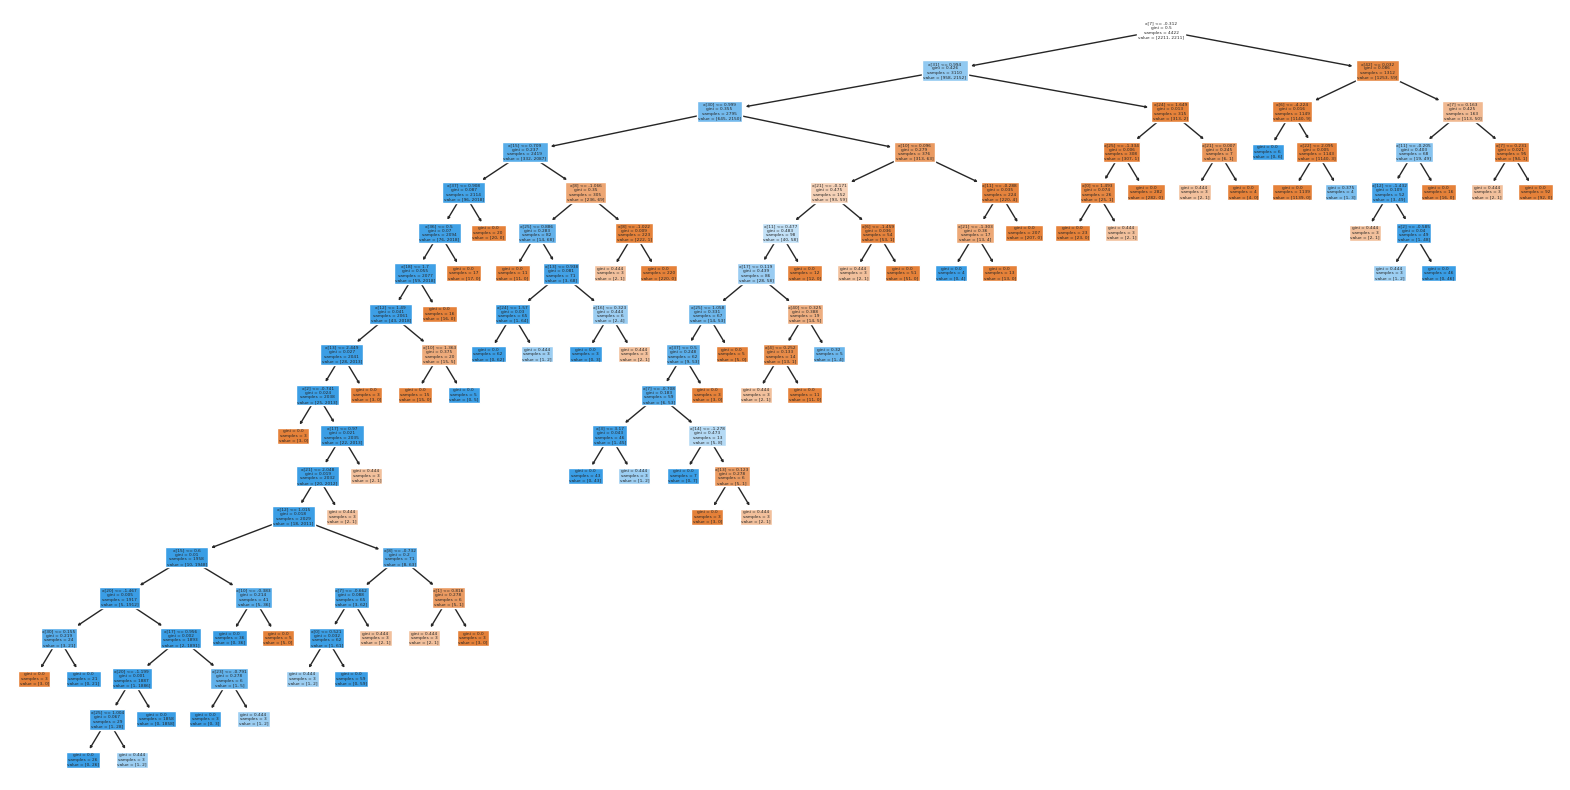

In [43]:
plt.figure(figsize=(20, 10))
plot_tree(tree_fit.best_estimator_['DT'], filled=True)
plt.show()

Adicionalmente mostramos cuales son las variables más importantes para el árbol:

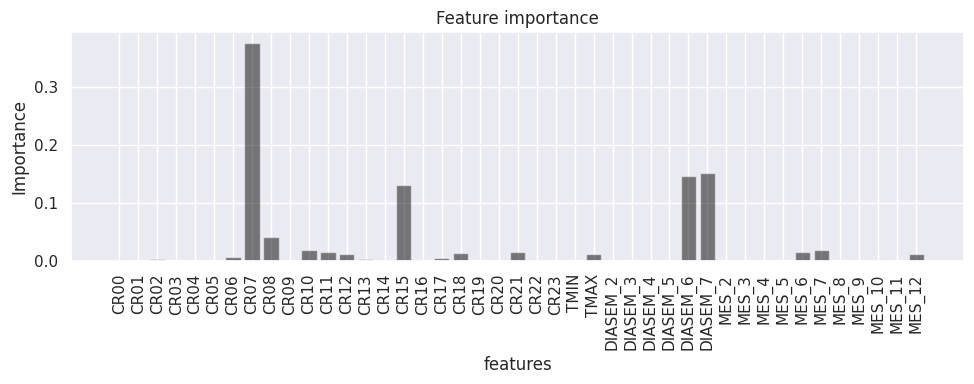

In [44]:
plt.figure(figsize=(10, 4))
index = np.arange(len(X_train[INPUTS_DT].columns))
bar_width = 0.35
plt.bar(index, tree_fit.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('Importance')
plt.title('Feature importance')
plt.xticks(index, X_train[INPUTS_DT].columns, rotation=90)
plt.tight_layout()
plt.show()

A continuación vamos a mostrar las métricas obtenidas por el árbol en el dataset de entrenamiento:

In [45]:
metrics_summary(tree_fit, X_train[INPUTS_DT], y_train, 0.5)

Confusion matrix
[[2203    8]
 [  13 2198]]
Confusion matrix with percentages
[[1.   0.  ]
 [0.01 0.99]]
Accuracy
0.9952510176390773
Precision
0.9963735267452403
Recall
0.9941203075531434
F1
0.9952456418383518
ROC_AUC_SCORE
0.9999305515921891


Mostramos estos resultados gráficamente:

In [46]:
y_train = y_train.astype('category')
CT.plotClassPerformance(y_train, tree_fit.predict_proba(X_train[INPUTS_DT]), selClass = 1)
plt.show()

NameError: name 'CT' is not defined

Ahora miramos esas mismas métricas, pero sobre el dataset de test:

In [47]:
metrics_summary(tree_fit, X_test[INPUTS_DT], y_test, 0.5)

Confusion matrix
[[541  12]
 [  7  16]]
Confusion matrix with percentages
[[0.98 0.02]
 [0.3  0.7 ]]
Accuracy
0.9670138888888888
Precision
0.5714285714285714
Recall
0.6956521739130435
F1
0.6274509803921569
ROC_AUC_SCORE
0.8784102523783316


Lo mostramos también gráficamente:

In [ ]:
y_test = y_test.astype('category')
CT.plotClassPerformance(y_test, tree_fit.predict_proba(X_test[INPUTS_DT]), selClass = 1)
plt.show()

#### 1.3. Ajusta un bagged tree para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

In [48]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
INPUTS_BT=INPUTS_DT
param_BT = { 'n_estimators': np.arange(2, 50, 10) }
base_estimator =  Pipeline(steps=[('DT', 
                                    DecisionTreeClassifier( criterion='gini',  # impurity measure
                                                            random_state=2023))]) # For replication
                                                            
bag_class_estim = BaggingClassifier(base_estimator=base_estimator,random_state=2023)

nFolds=10
bag_tree_fit=GridSearchCV(
    estimator=bag_class_estim,
    param_grid=param_BT,
    cv=nFolds,
    scoring='accuracy',
    n_jobs=-1)
# fit the bagged trees                 
bag_tree_fit.fit(X_train[INPUTS_BT], y_train)

/home/carlotamoh/Dropbox/Documents/MasterBD/ML2/Labs/ml2-ensemble/venv-ml2-ensemble/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/carlotamoh/Dropbox/Documents/MasterBD/ML2/Labs/ml2-ensemble/venv-ml2-ensemble/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/carlotamoh/Dropbox/Documents/MasterBD/ML2/Labs/ml2-ensemble/venv-ml2-ensemble/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/carlotamoh/Dropbox/Documents/MasterBD/ML2/Labs/ml2-ensemble/venv-ml2-ensemble/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in versi

GridSearchCV(cv=10,
             estimator=BaggingClassifier(base_estimator=Pipeline(steps=[('DT',
                                                                         DecisionTreeClassifier(random_state=2023))]),
                                         random_state=2023),
             n_jobs=-1,
             param_grid={'n_estimators': array([ 2, 12, 22, 32, 42])},
             scoring='accuracy')

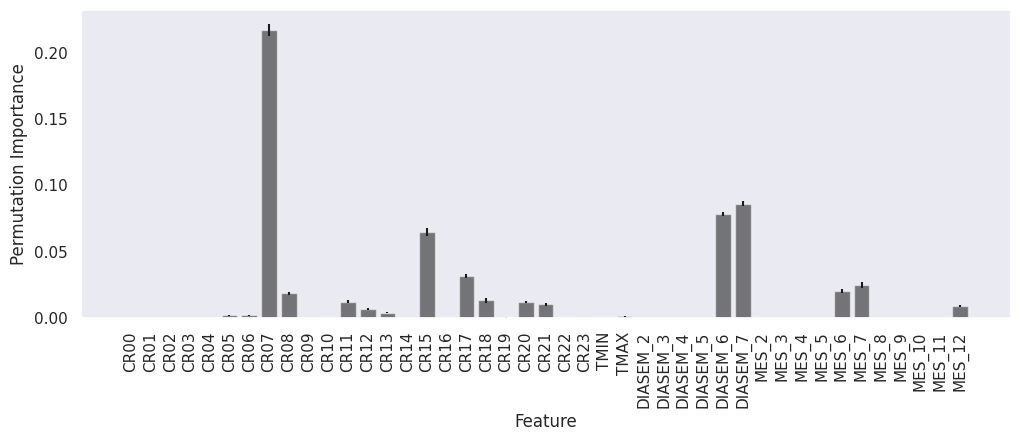

In [49]:
importances_bag_class_estim = permutation_importance(bag_tree_fit, 
                                    X_train[INPUTS_BT], y_train,
                                    n_repeats=10,
                                    random_state=0)
fig = plt.figure(2, figsize=(12, 4)) 
plt.bar(INPUTS_BT, importances_bag_class_estim.importances_mean, yerr=importances_bag_class_estim.importances_std,color='black', alpha=0.5)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [50]:
metrics_summary(bag_tree_fit, X_train[INPUTS_DT], y_train, 0.5)

Confusion matrix
[[2211    0]
 [   0 2211]]
Confusion matrix with percentages
[[1. 0.]
 [0. 1.]]
Accuracy
1.0
Precision
1.0
Recall
1.0
F1
1.0
ROC_AUC_SCORE
1.0


In [51]:
y_train = y_train.astype('category')
# CT.plotClassPerformance(y_train, bag_tree_fit.predict_proba(X_train[INPUTS_BT]), selClass = 1)
plt.show()

NameError: name 'CT' is not defined

In [84]:
metrics_summary(bag_tree_fit, X_test[INPUTS_DT], y_test, 0.5)

Confusion matrix
[[545   8]
 [  7  16]]
Confusion matrix with percentages
[[0.99 0.01]
 [0.3  0.7 ]]
Accuracy
0.9739583333333334
Precision
0.6666666666666666
Recall
0.6956521739130435
F1
0.6808510638297872
ROC_AUC_SCORE
0.961160468590298


In [ ]:
y_train = y_train.astype('category')
# CT.plotClassPerformance(y_test, bag_tree_fit.predict_proba(X_test[INPUTS_BT]), selClass = 1)
plt.show()

#### 1.4. Ajusta un random forest para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

In [ ]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 1.5. Ajusta un gradient boosting para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

Con el fin de ampliar el rango de modelos empleados para resolver el problema proponemos la implementación de dos técnicas diferentes basadas en boosting:

+ En primer lugar, emplearemos el paquete `lightgbm`, con una implementación ligera del algoritmo de gradient boosting que presenta ventajas en cuanto a la optimización del uso de memoria y velocidad de computación

+ En segundo lugar, emplearemos adicionalmente el paquete `xgboost`, que a pesar de ser algo más lento se encuentra entre los paquetes más populares para implementar la técnica de Gradient Boosting.

Adicionalmente, utilizaremos una aproximación algo diferente a la optimización de hiperparámetros. Dado que la búsqueda de la complejidad óptima mediante GridSearch es computacionalmente intensiva, queremos explorar la opción de emplear algoritmos basado en una búsqueda aleatoria guiada, que permitan una mayor exploración del espacio de soluciones. Esto es especialmente crítico cuando queremos encontrar combinaciones de varios hiperparámetros, donde podemos vernos significativamente limitados si queremos realizar una búsqueda por GridSearch (debido al problema combinatorio que supone). 

El algoritmo por el que nos decantamos es la optimización bayesiana, implementada en la clase `ModelOptimizer` descrita a continuación. Esta clase utiliza los métodos de la librería `bayes_opt` mediante una implementación que permite una aplicación flexible a cualquier modelo, independientemente de si se emplean hiperparámetros `int` o `float`.

Dentro de la clase definimos una `black_box_function`, que será la función a optimizar. En este caso, puesto que se trata de un problema de clasificación, podemos escoger métricas como el accuracy, el ROC-AUC, cross-val score, etc. En este caso, emplearemos como métrica el `cross_val_score` a la hora de determinar la complejidad óptima del árbol, de manera similar a como lo hace GridSearch. La métrica de scoring empleada dentro de la función será el `accuracy`, puesto que no tenemos información de si es más importante un `sensititity` elevado o un `specificity` elevado. 

A continuación, se define la función que optimiza el modelo (`optimize_model`). La función incluye un wrapper para la función de optimización anteriormente descrita, el optimizador bayesiano y el empleo de una utility function, que funciona como una función de adquisición para cada uno de los nuevos puntos dentro de un for loop. La razón para el uso de esta fnción es que la implementación simple del optimizador bayesiano sugiere combinaciones de parámetros escogidos dentro de un espectro continuo, por lo que parámetros que necesiten ser discretos (como por ejemplo el número de estimadores empleados en Gradient Boosting) no podrían ser optimizados. Es por ello que se utiliza una implementación que permite un mayor control sobre la búsqueda, donde cada uno de los nuevos puntos es sugerido por la `utility_function` y los parámetros definidos como `int` pueden ser transformados manualmente. Para más información sobre el algoritmo y su implementación, referirse a los siguientes enlaces:

+ https://github.com/fmfn/BayesianOptimization
+ https://towardsdatascience.com/bayesian-optimization-with-python-85c66df711ec

##### Bayesian optimization

In [114]:
from sklearn.model_selection import cross_val_score
class ModelOptimizer:
    """
    Class used for hyperparameter tuning based on Bayesian Optimization

    Functions based on code from: https://towardsdatascience.com/bayesian-optimization-with-python-85c66df711ec
    """
    def __init__(self, scoring):
        self.optimizer = None
        self.best_optimizer = None
        self.scoring = scoring

    def black_box_function(self, X_train_scale, y_train, model, **params):
        """
        Black box function for optimization algorithm
        """
        model = model.set_params(**params)
        f = cross_val_score(model, X_train_scale, y_train,
                            scoring=self.scoring, cv=10)
        
        return f.mean()

    def optimize_model(self, pbounds, X_train_scale, y_train, model, int_params, n_iter=25):
        """
        Optimize 

        """
        def opt_function(**params):
            """
            Function wrapper
            """
            return self.black_box_function(X_train_scale,
                                           y_train,
                                           model,
                                           **params)
        # create optimizer
        optimizer = BayesianOptimization(f = None,
                                         pbounds=pbounds,
                                         verbose=2,
                                         random_state=2022)

        # declare acquisition function used for getting new values of the
        # hyperparams
        utility = UtilityFunction(kind = "ucb", kappa = 1.96, xi = 0.01)

        # Optimization for loop.
        for i in range(n_iter):
            # Get optimizer to suggest new parameter values to try using the
            # specified acquisition function.
            next_point = optimizer.suggest(utility)
            # Force degree from float to int.
            for int_param in int_params:
                next_point[int_param] = int(next_point[int_param])
            # Evaluate the output of the black_box_function using 
            # the new parameter values.
            target = opt_function(**next_point)
            try:
                # Update the optimizer with the evaluation results. 
                # This should be in try-except to catch any errors!
                optimizer.register(params = next_point, target = target)
            except:
                pass
                   
        print("Best result: {}.".format(optimizer.max["params"]))

        self.optimizer = optimizer
        self.best_optimizer = optimizer.max

        return optimizer.max["params"]

##### LGBM

In [115]:
# define basic model structure
model_lgbm = lgb.LGBMClassifier(objective="binary",
                                random_state=2022)

# set bounds for parameter search
pbounds_lgbm = {"n_estimators": (50, 100),
                "learning_rate": (0.01, 0.1),
                "max_depth": (1, 3)}

# specify which parameters need to be treated as int
int_params_lgbm = ["n_estimators", "max_depth"]

# initialize optimizer
optimizer = ModelOptimizer(scoring="accuracy")

# optimize model
params_lgbm = optimizer.optimize_model(pbounds=pbounds_lgbm, X_train_scale=X_train, 
                                      y_train=y_train, model=model_lgbm, 
                                      int_params=int_params_lgbm)

# transform hyperparameters to int if needed
hyper_params = { (k):(int(np.round(v, 0)) if k in int_params_lgbm else round(v, 2)) for k, v in params_lgbm.items()}

# fit model using hyperparameters
lgbm = model_lgbm.set_params(**hyper_params)
lgbm.fit(X_train, y_train)

Best result: {'learning_rate': 0.1, 'max_depth': 3.0, 'n_estimators': 97.0}.


LGBMClassifier(max_depth=3, n_estimators=97, objective='binary',
               random_state=2022)

In [105]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
# check model

lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 91,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': 2022,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

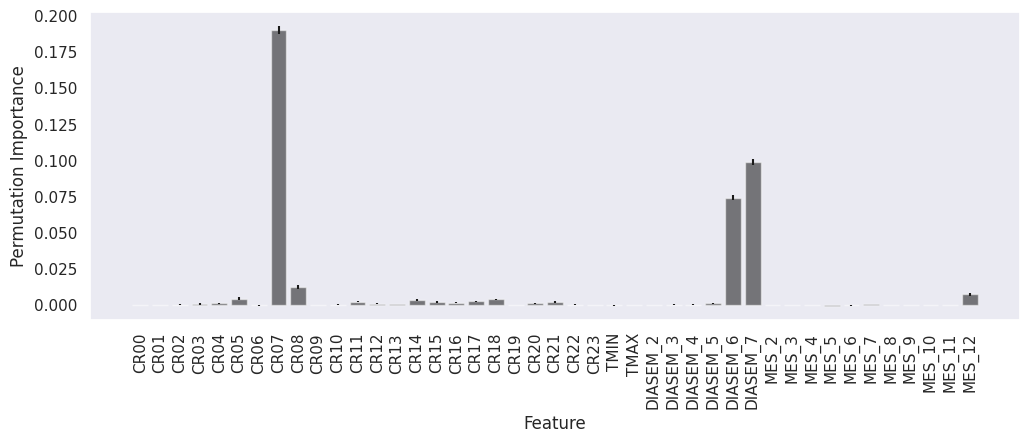

In [106]:
importance_lgbm = permutation_importance(lgbm, X_train, y_train, n_repeats=10, random_state=0)
fig = plt.figure(2, figsize=(12, 4)) 
plt.bar(INPUTS_BT, importance_lgbm.importances_mean, yerr=importance_lgbm.importances_std,color='black', alpha=0.5)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.xticks(rotation=90)
plt.grid()
plt.show()

Podemos comprobar que la importancia de las variables empleadas es similar a lo que observamos con los algoritmos anteriores, sindo el coeficiente de reparto $CR07$ y los días de la semana $Sábado$ y $Domingo$ las variables más importantes. 

In [107]:
metrics_summary(lgbm, X_train, y_train, 0.5)

Confusion matrix
[[2200   11]
 [   9 2202]]
Confusion matrix with percentages
[[1. 0.]
 [0. 1.]]
Accuracy
0.9954771596562642
Precision
0.9950293718933574
Recall
0.9959294436906377
F1
0.9954792043399638
ROC_AUC_SCORE
0.9998940374808659


Podemos observar que la performance del modelo en el dataset de training es casi perfecta. Sin embargo, esto no garantiza los mismos resultados en el dataset de testing, y de hecho es posible que nos estemos enfrentando a un problema de overfitting.

In [108]:
y_train = y_train.astype('category')
# CT.plotClassPerformance(y_train, bag_tree_fit.predict_proba(X_train[INPUTS_BT]), selClass = 1)
plt.show()

In [109]:
metrics_summary(lgbm, X_test, y_test, 0.5)

Confusion matrix
[[548   5]
 [  4  19]]
Confusion matrix with percentages
[[0.99 0.01]
 [0.17 0.83]]
Accuracy
0.984375
Precision
0.7916666666666666
Recall
0.8260869565217391
F1
0.8085106382978724
ROC_AUC_SCORE
0.9794795188300967


Podemos realizar una comparación del modelo obtenido mediante el método de optimización bayesiana modelo obtenido por GridSearch:

In [110]:
params_lgbm_searcg = {
    'lgbm__n_estimators': np.arange(50, 100, 5),
    'lgbm__learning_rate': np.arange(0.01, 0.1, 0.005),
    'lgbm__max_depth': np.arange(1, 3, 1)
}

pipe_lgbm = Pipeline(steps=[('lgbm', lgb.LGBMClassifier(objective="binary", random_state=2022))])

nFolds = 10
lgbm_search = GridSearchCV(
    estimator=pipe_lgbm, # Structure of the model to use
    param_grid=params_lgbm_searcg, # Defined grid to search in
    n_jobs=-1, # Number of cores to use (parallelize)
    scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
    cv=nFolds
    ) # Number of Folds 
                        
lgbm_search.fit(X_train, y_train) # Search in grid
print("LGBM Search Trained")

LGBM Search Trained


In [112]:
lgbm_search.best_estimator_['lgbm'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.08999999999999998,
 'max_depth': 2,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 95,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': 2022,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

Podemos ver que los parámetros obtenidos son bastante similares:

+ n_estimators: 97 vs 95
+ learning_rate: 0.1 vs 0.09
+ max_depth: 3 vs 2

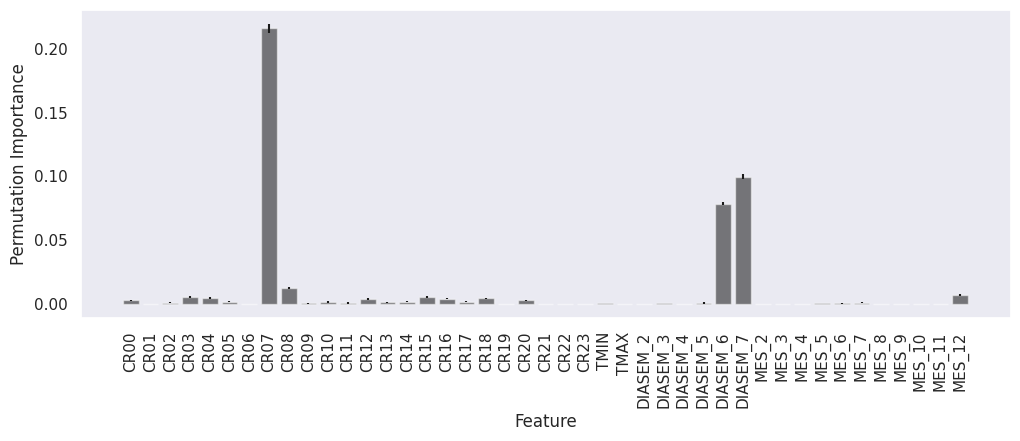

In [113]:
importance_lgbm_search = permutation_importance(lgbm_search.best_estimator_['lgbm'], X_train, y_train, n_repeats=10, random_state=0)
fig = plt.figure(2, figsize=(12, 4)) 
plt.bar(INPUTS_BT, importance_lgbm_search.importances_mean, yerr=importance_lgbm_search.importances_std,color='black', alpha=0.5)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.xticks(rotation=90)
plt.grid()
plt.show()

Del mismo modo, el perfil general de importance de las variables parece similar

In [116]:
metrics_summary(lgbm, X_train, y_train, 0.5)

Confusion matrix
[[2204    7]
 [   9 2202]]
Confusion matrix with percentages
[[1. 0.]
 [0. 1.]]
Accuracy
0.9963817277250113
Precision
0.996831145314622
Recall
0.9959294436906377
F1
0.9963800904977376
ROC_AUC_SCORE
0.9999079476185129


In [117]:
metrics_summary(lgbm, X_test, y_test, 0.5)

Confusion matrix
[[548   5]
 [  4  19]]
Confusion matrix with percentages
[[0.99 0.01]
 [0.17 0.83]]
Accuracy
0.984375
Precision
0.7916666666666666
Recall
0.8260869565217391
F1
0.8085106382978724
ROC_AUC_SCORE
0.9784574258982625


Finalmente, observamos que el desempeño del modelo en los conjuntos de train y test es muy parecido. Con este experimento hemos podido comprobar que el método de optimización bayesiana es una buena alternativa a GridSearch a la hora de escoger la complejidad del modelo, que además permite iteraciones mucho más rápidas y ligeras y amplia significativamente el rango de hiperparámetros que podemos optimizar.

#### 1.6. Utiliza staking con tus mejores tres modelos para intentar mejorar la soluciones obtenidas.
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación

In [ ]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 1.7. Crea un número de variables reducido que contengan la información recogida en las variables CR00 a CR23 y crea un árbol sencillo basado en estas variables.
- El conjunto de variables creado tienen que ser una combinación lineal de CR00, ..., CR23
- Optimiza la complejidad del árbol
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Analiza la lógica que emplea para determinar si es festivo
- Revisa la importancia de las variables, explicando el significado físico de las variables más importantes
- Compara los errores en TR y TS y la lógica del modelo con el creado anteriormente en el apartado 1.2.


In [ ]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 1.8 Compara todos los modelos creados en términos de complejidad, interpretabilidad y errores
- Discute el posible impacto que tiene en los modelos el que existan menos festivos que laborables
- Compara la complejidad en términos de nº de parámetros y estructura del modelo, variables utilizadas, importancia de las mismas
- Compara la capacidad de generalización de los modelos utilizando TS y las diferencias en las matrices de confusión
- Estudia la tasa de fallos de los modelos dependiendo del día de la semana
- Indica qué modelo o modelos son los más prometedores para poner en producción, justificando la selección

In [ ]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


---
### 2. VALIDACIÓN FINAL DE LOS MODELOS CON EL DATASET VAL_DATOS_DEM_C3

Se correpondería como si los todos los modelos creados anteriormente se ponen en producción el 1 enero de 2022 y se tienen estimando la festividad durante todo el año para ver qué tal funcionan.

Recuerda, no se debería ver ningún resultado sobre este dataset hasta haber completado todos los apartados anteriores.

Carga datos de validación

In [ ]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

df_val = pd.read_csv('data/input/VAL_DATOS_DEM_C3.csv')

# parseamos la fecha (cadena) para que sea un datetime con formato dd/mm/yyyy 
# esta variable NO se puede utilizar como entrada en los modelos
df_val.FECHA = pd.to_datetime(df_val.FECHA, format='%d/%m/%Y') 
s=df_val.loc[:,'FECHA']
df_val['FECHA'] =  s.dt.date

# eliminamos las variables que no se pueden usar como entradas en los modelos
del df_val['ANNO']
del df_val['DIA']

print('Tamaño de df_val con los datos cargados:', df_val.shape)
print('Dataframe con todos los datos leidos (filas: días, columnas: variables):')
df_val

#### 2.1. Compara los errores obtenidos en validación con los observados previamente en ajuste/test
- Una vez terminados todos los ajustes de los modelos en el apartado 1.1., ejecuta los mismos para estimar si los días de 2022 son festivos o no (conjunto df_val)
- Muestra los resultados de clasificación obtenidos en el nuevo dataset (accuray y tablas de confusión de cada modelo)
- Discute si los errores obtenidos son coherentes con lo que se esperaba como resultado de los análisis previos para estimar la capacidad de generalización de cada uno de los modelos

In [ ]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 2.2. Análisis de los días peor clasificados
- Indica en una tabla la lista de los días que se han clasificado incorrectamente por cada uno de los modelos considerados
- Comenta las posibles diferencias y semejanzas, intentando buscar una justificación de por qué ha ocurrido el error de clasificación
- Muestra gráficamente los perfiles de 24 horas de los 3 días más difíciles de clasificar para los modelos, comparándolos con lo esperado según el día de la semana correspondiente

In [ ]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
